This notebook takes over the analysis of the data done in the notebook about the triple event analysis and the network loglikelihood. The major goal is to get rid of the incoherances between the two as well as to have better graphs for the report.

In [1]:
%matplotlib inline 

#first we need to set bigger characters for the titles, labels and thicks.
import matplotlib
import matplotlib.pyplot as plt
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 12}

matplotlib.rc('font', **font)


Duration: 32.0s Start: 1186741846 End: 1186741878


Text(0.5,1,'Virgo data')

/home/justin/.local/lib/python2.7/site-packages/matplotlib/font_manager.py:1333: UserWarning: findfont: Font family [u'normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


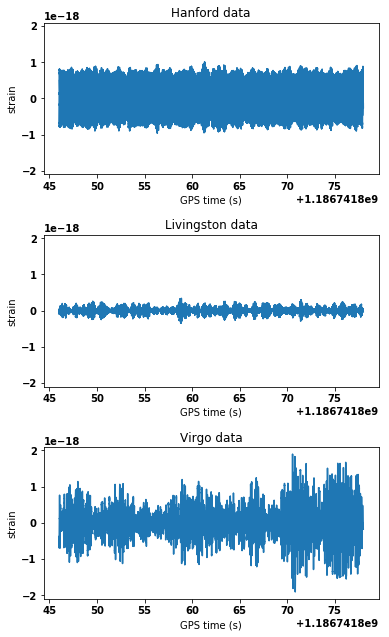

In [2]:
#first analysis of the raw data presented --> check which one it exactly is
from pycbc.catalog import Merger
m= Merger("GW170814")
ts_han=m.strain('H1')
ts_liv=m.strain('L1')
ts_vir=m.strain('V1')

print("Duration: {}s Start: {} End: {}".format(ts_han.duration, 
                                              int(ts_han.start_time),
                                              int(ts_han.end_time)))

f=plt.figure()
ax=f.subplots(nrows=3, sharey=True)
f.subplots_adjust(bottom=18, top=20, wspace= 0.4, hspace=0.4)
ax[0].plot(ts_han.sample_times, ts_han, label='H1')
ax[1].plot(ts_liv.sample_times, ts_liv, label='L1')
ax[2].plot(ts_vir.sample_times, ts_vir, label='V1')
for i in range(3):
        ax[i].set_xlabel('GPS time (s)')
        ax[i].set_ylabel('strain')
ax[0].set_title("Hanford data")
ax[1].set_title('Livingston data')
ax[2].set_title("Virgo data")

**to add in the report**: By looking at these different figures, one sees that the Virgo detector is more noisy than the two LIGO detectors.

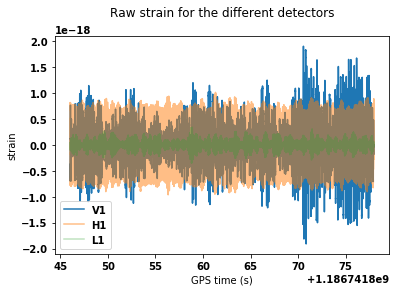

In [3]:
#representation of the event on the same plot
data={}
for i in ['L1','H1','V1']:
    data[i]=m.strain(i)
alphas=[1,0.5,0.3]
k=0
for j in data:
    plt.plot(data[j].sample_times, data[j], label=j, alpha=alphas[k])
    k+=1
plt.ylabel("strain")
plt.xlabel('GPS time (s)')
plt.title("Raw strain for the different detectors", pad=20)
plt.legend(loc="best")

We can zoom into one second around the peak of the event in each detectors. This zoom for the event enables to see the low frequency behaviour since it dominates over the lower frequencies and the signal itself

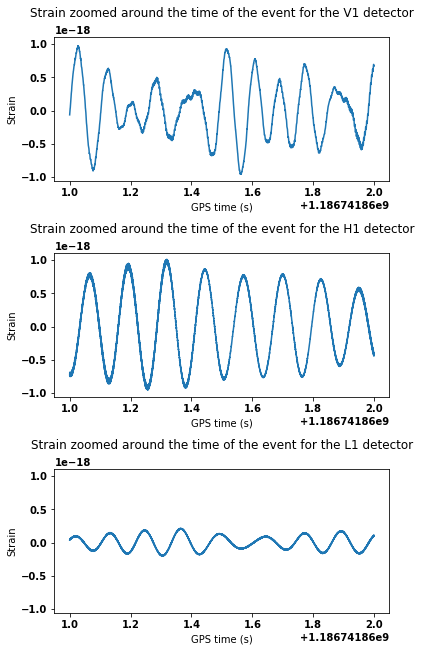

In [4]:
f=plt.figure()
ax=f.subplots(nrows=3, sharey=True)
f.subplots_adjust(bottom=18, top=20, wspace= 0.4, hspace=0.5)
j=0
for i in data:
    zoom=data[i].time_slice(m.time-0.5, m.time+0.5)
    ax[j].plot(zoom.sample_times, zoom, label=i)
    ax[j].set_title("Strain zoomed around the time of the event for the %s detector" %i, pad=20)
    ax[j].set_xlabel("GPS time (s)")
    ax[j].set_ylabel("Strain")
    j+=1

We see that the signals of the detectors are not exactlty the same. This can be improved by the use of a highpass filter. Once this is applied, the range of the frequencies is rescaled to the same order of magnitides. The problem is that the high frequency noises will still dominate. This can be corrected only by applying a whitening process onto the data.

In order to proceed to the high pass, we directly use the build-in function of pycbc. 

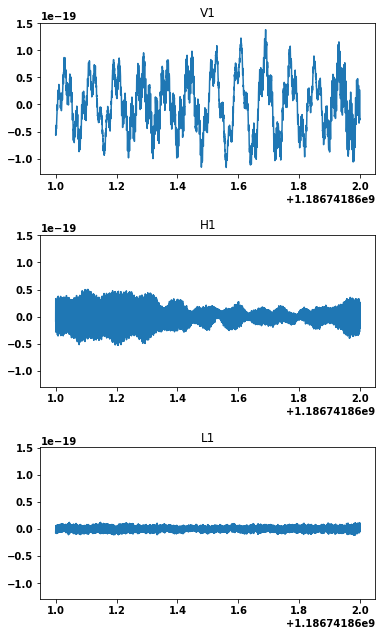

In [5]:
#done rapidly here, not that important for the master thesis
f=plt.figure()
ax=f.subplots(nrows=3, sharey=True)
f.subplots_adjust(bottom=18, top=20, wspace= 0.4, hspace=0.4)
j=0
for i in data:
    high_data=data[i].highpass_fir(15,512)
    zoom=high_data.time_slice(m.time-0.5, m.time+0.5)
    ax[j].plot(zoom.sample_times, zoom, label=i)
    ax[j].set_title(i)
    j+=1

We can than turn to an estimation of the power spectral density of the data, using a Welsh method. This enables to see the frequencie whith an excess of power and also particularities of somes frequencies. It enables to have an estimate of the noise present in the detector

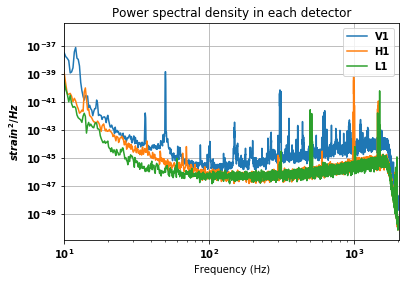

In [6]:
#the psd estimation is done with Welsh method for 4s time slices
for i in data:
    psd=data[i].psd(4)
    plt.loglog(psd.sample_frequencies, psd, label=i)
plt.xlabel("Frequency (Hz)")
plt.ylabel("$strain^2/Hz$")
plt.xlim(10,2048)
plt.legend(loc="best")
plt.title("Power spectral density in each detector")
plt.grid()

we see that the precision obtained is better in the Ligo detectors than the Virgo one. In addition, there is the presence of a cut off at about 2kHz, which is due to the filter applied in frequency in order to resample the data at 4096Hz. There is also the 60Hz power line. In addition, the peaks are the viloin modes of the mirror suspensions, hence there resonance frequency.  

The next step is to **whiten** the data. That means that we "clean" the data is order to get rid of some of the unuseful fresuency content of the data. The goal of this manipulation is to clean make all the frequencies used contribute with the same weight. This enables to visualize the deviation from the noise. In addition to the witening, we also use a bandpass in order to focus only on a sepcific freqeuncy range.

The witened data is obtained by taking an estimate of the power spectral denisty from the data and flatten the response in frequency.

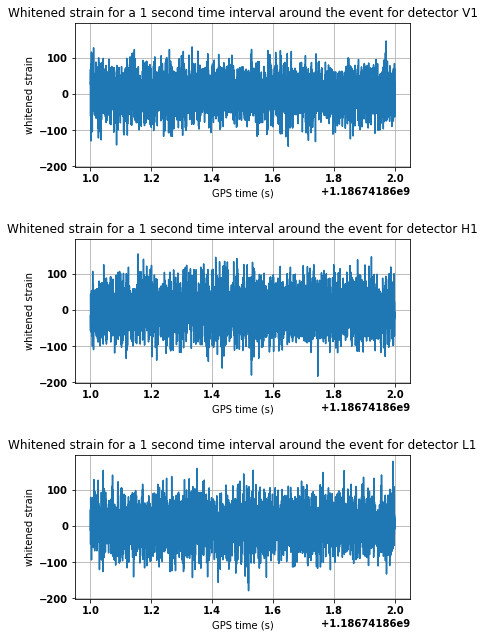

In [7]:
whitened={}
f=plt.figure()
ax=f.subplots(nrows=3, sharey=True)
f.subplots_adjust(bottom=18, top=20, wspace= 0.4, hspace=0.5)
j=0
for i in data:
    whitened[i]=data[i].whiten(4,4)
    zoom= whitened[i].time_slice(m.time-0.5, m.time+0.5)
    ax[j].plot(zoom.sample_times, zoom)
    ax[j].set_xlabel("GPS time (s)")
    ax[j].set_ylabel("whitened strain")
    ax[j].set_title("Whitened strain for a 1 second time interval around the event for detector %s" %i)
    ax[j].grid()
    j+=1

All theses strains can be represented on the same graph as well. It is not that useful except that is shows that all the data indeed return in the same frequency range, which can also be seen in the plots above 

In our case, we knwo that we look for a BBH event. In the whitened data, the signal is still drawned in a lot of noise. In order to be able to see better the signal due to the event, we bandpass even more the whitened signal. So, we end up with a time series focused on the frequeny range that enables to have the clear signature of the event. This is the case for a bandpass between 30Hz and 250Hz. This is obtained using a combination of the default highpass nd lowpass function implemented in pycbc

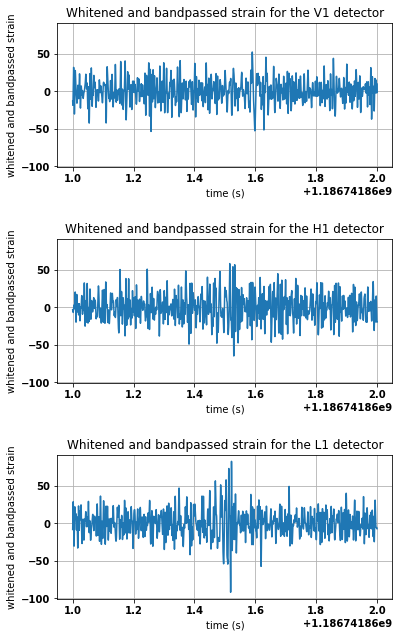

In [8]:
f=plt.figure()
ax=f.subplots(nrows=3, sharey=True)
f.subplots_adjust(bottom=18, top=20, wspace= 0.4, hspace=0.5)
j=0
for i in whitened:
    bsp=whitened[i].highpass_fir(30,512).lowpass_fir(250,512)
    #we still represent only a part focused close to the event
    zoom=bsp.time_slice(m.time-0.5, m.time+0.5)
    ax[j].plot(zoom.sample_times, zoom)
    ax[j].set_xlabel("time (s)")
    ax[j].set_ylabel("whitened and bandpassed strain")
    ax[j].set_title("Whitened and bandpassed strain for the %s detector" %i)
    ax[j].grid()
    j+=1

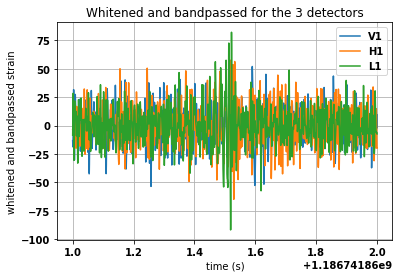

In [9]:
for i in whitened:
    bps=whitened[i].highpass_fir(30,512).lowpass_fir(250,512)
    zoom=bps.time_slice(m.time-0.5, m.time+0.5)
    plt.plot(zoom.sample_times, zoom, label=i)
plt.xlabel("time (s)")
plt.ylabel("whitened and bandpassed strain")
plt.title("Whitened and bandpassed for the 3 detectors")
plt.grid()
plt.legend(loc="best")

The three plots above have each an excess signal appearing in the data around the time the event. It peaks a bit out of the noise but is still not that easy to see. It is then possible to focus even more the data around the event in order to seen even better what happens. First we simply zoom on the event time. Second, we can translate the signal in time in order to gave it alligned in the three detectors, artificially removing the shift between the detectors.

Text(0,0.5,'whitened and bandpassed strain')

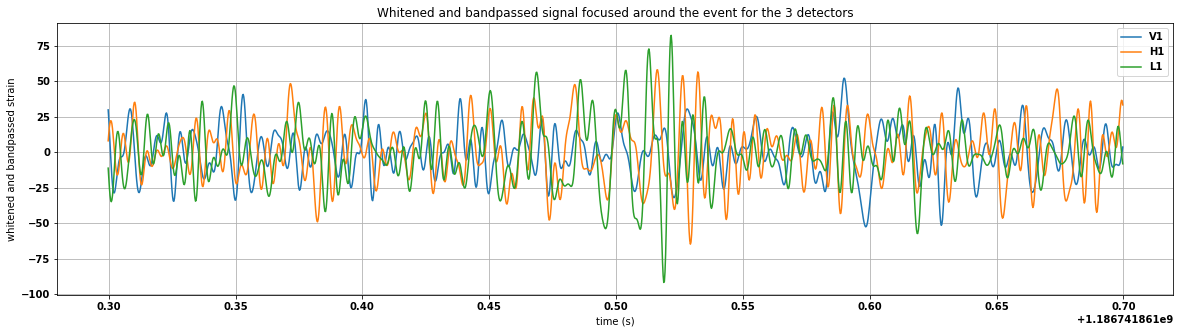

In [10]:
f=plt.figure(figsize=(20,5))

for i in whitened:
    #we still focus on the same bandpassed frequencies
    bps=whitened[i].highpass_fir(30,512).lowpass_fir(250,512)
    zoom=bps.time_slice(m.time-0.2, m.time+0.2)
    plt.plot(zoom.sample_times, zoom, label=i)

plt.grid()
plt.legend(loc="best")
plt.title("Whitened and bandpassed signal focused around the event for the 3 detectors")
plt.xlabel("time (s)")
plt.ylabel("whitened and bandpassed strain")

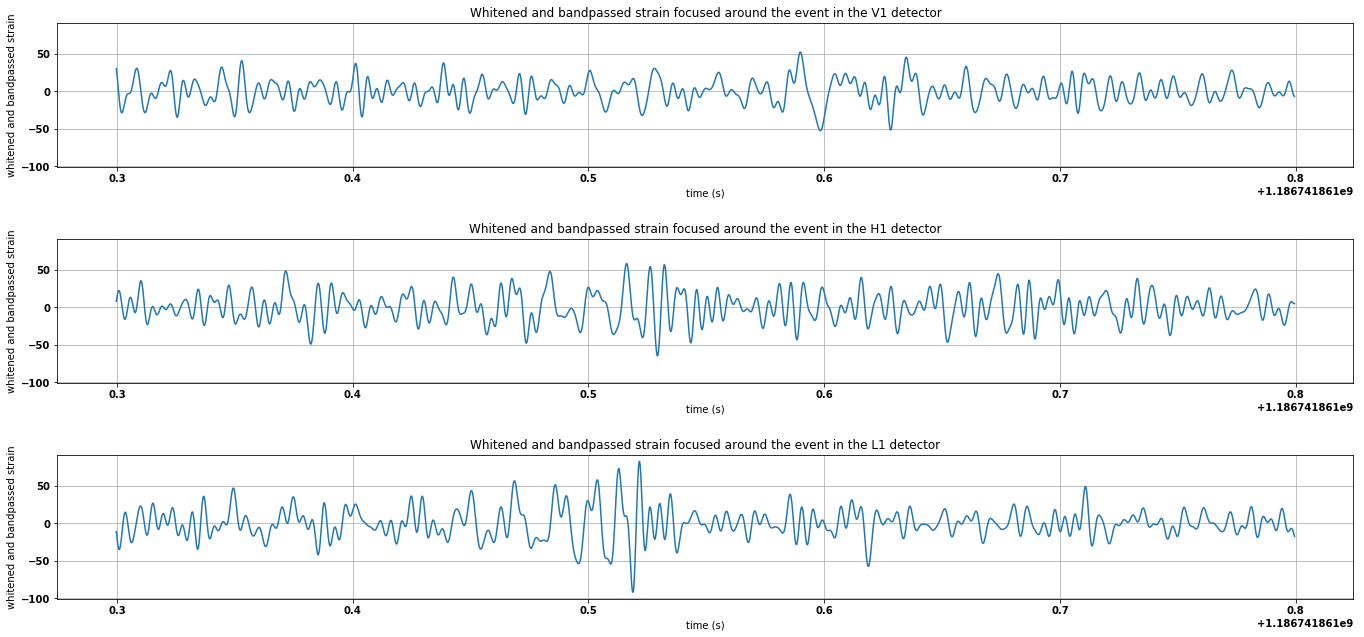

In [11]:
f=plt.figure()
ax=f.subplots(nrows=3, sharey=True)
f.subplots_adjust(left=2, right= 5, bottom=18, top=20, wspace= 0.4, hspace=0.5)
j=0
for i in whitened:
    bps=whitened[i].highpass_fir(30,512).lowpass_fir(250,512)
    zoom=bps.time_slice(m.time-0.2, m.time+0.3)
    ax[j].plot(zoom.sample_times, zoom)
    ax[j].set_xlabel("time (s)")
    ax[j].set_ylabel("whitened and bandpassed strain")
    ax[j].set_title("Whitened and bandpassed strain focused around the event in the %s detector" %i)
    ax[j].grid()
    j+=1

Because the superposition of the three events is unclear and that the signal is not well visible in the Vrigo detector, we only superpose the two datas in the LIGO detectors, where the Hanford data is shifted from 8ms in order to match the Livingston data. Note that the peaks has been found 14ms later in the Virgo detector than in the L1 detector.

Text(0,0.5,'whitened strain')

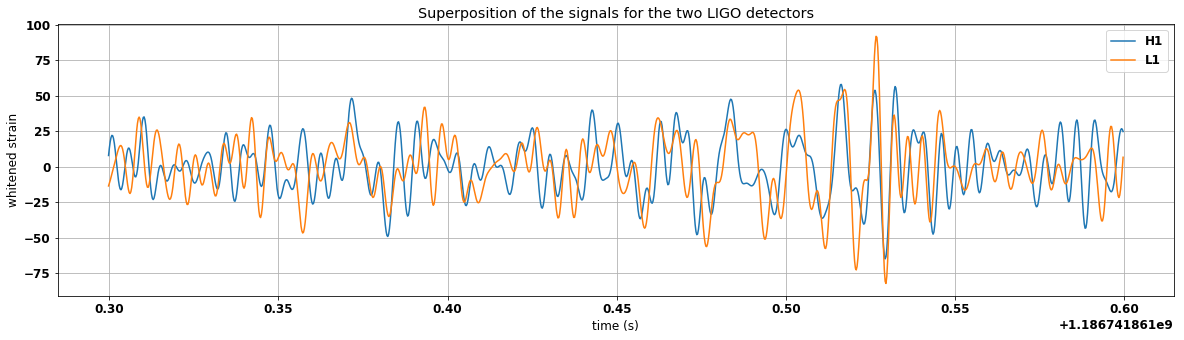

In [12]:
#first we need to set bigger characters for the titles, labels and thicks.
import matplotlib
import matplotlib.pyplot as plt
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 12}

matplotlib.rc('font', **font)
plt.figure(figsize=(20,5))
for i in whitened:
    bps= whitened[i].highpass_fir(30,512).lowpass_fir(250, 512)
    if i=="V1":
        print(" ")
    elif i=="L1":
        bps.roll(int(bps.sample_rate*0.008))
        bps*= -1
        zoom=bps.time_slice(m.time-0.2, m.time+0.1)
        plt.plot(zoom.sample_times, zoom, label=i)
    else:
        zoom=bps.time_slice(m.time-0.2, m.time+0.1)
        plt.plot(zoom.sample_times, zoom, label=i)
plt.grid()
plt.legend(loc="best")
plt.title("Superposition of the signals for the two LIGO detectors")
plt.xlabel("time (s)")
plt.ylabel("whitened strain")        
        

We can then do a **q transform** in order to have a visualisation of the signal. This enables to see where there is a higher density of the signal in the frequency domain. This is a bit like a spectrogram but the frequency bins used for the Fourrier transform are spaced more sparsely at high frequencies.

/home/justin/.local/lib/python2.7/site-packages/matplotlib/axes/_base.py:3477: UserWarning: Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive ylimits for log-scale axis; '


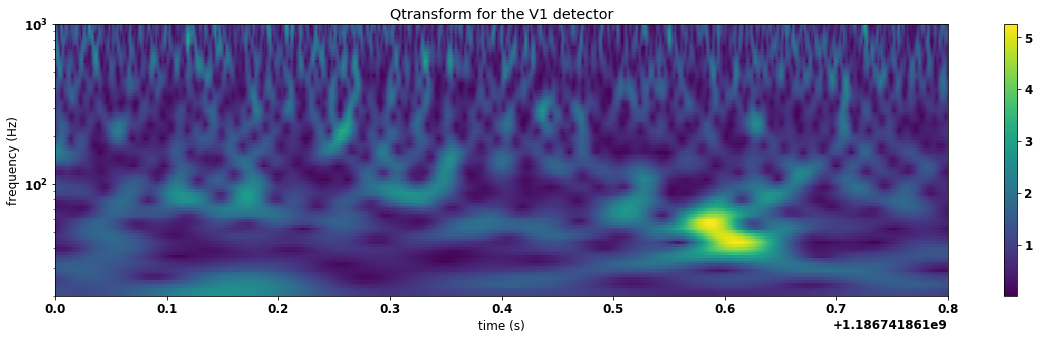

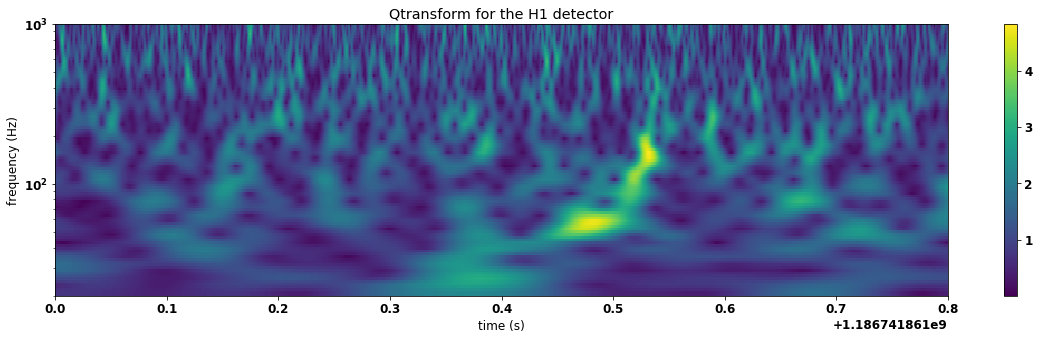

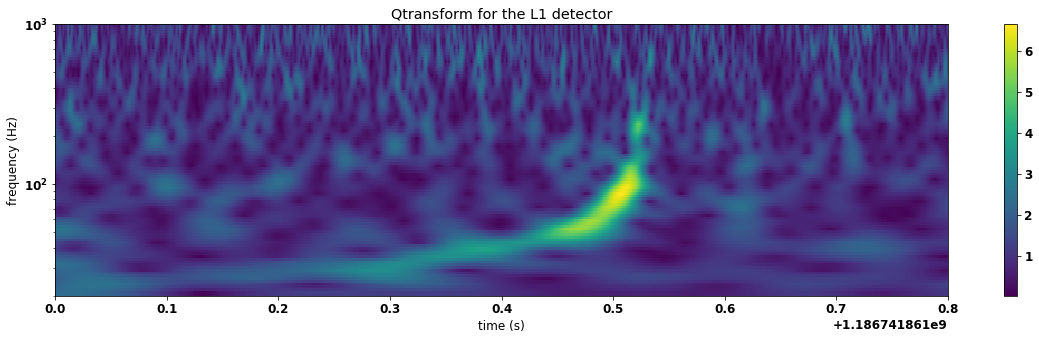

In [13]:
for i in whitened:
    zoom=whitened[i].time_slice(m.time-5, m.time+5)
    times, freqs, power = zoom.qtransform(0.001, logfsteps=100 , qrange=(10,10), frange=(20,1000))
    plt.figure(figsize=(20,5))
    plt.pcolormesh(times, freqs, power**0.5)
    plt.xlim(m.time-0.5, m.time+0.3)
    plt.title("Qtransform for the %s detector" %i)
    plt.yscale('log')
    plt.xlabel("time (s)")
    plt.ylabel("frequency (Hz)")
    plt.ylim(0,1000)
    plt.colorbar()

Text(0,0.5,'Normalized amplitude')

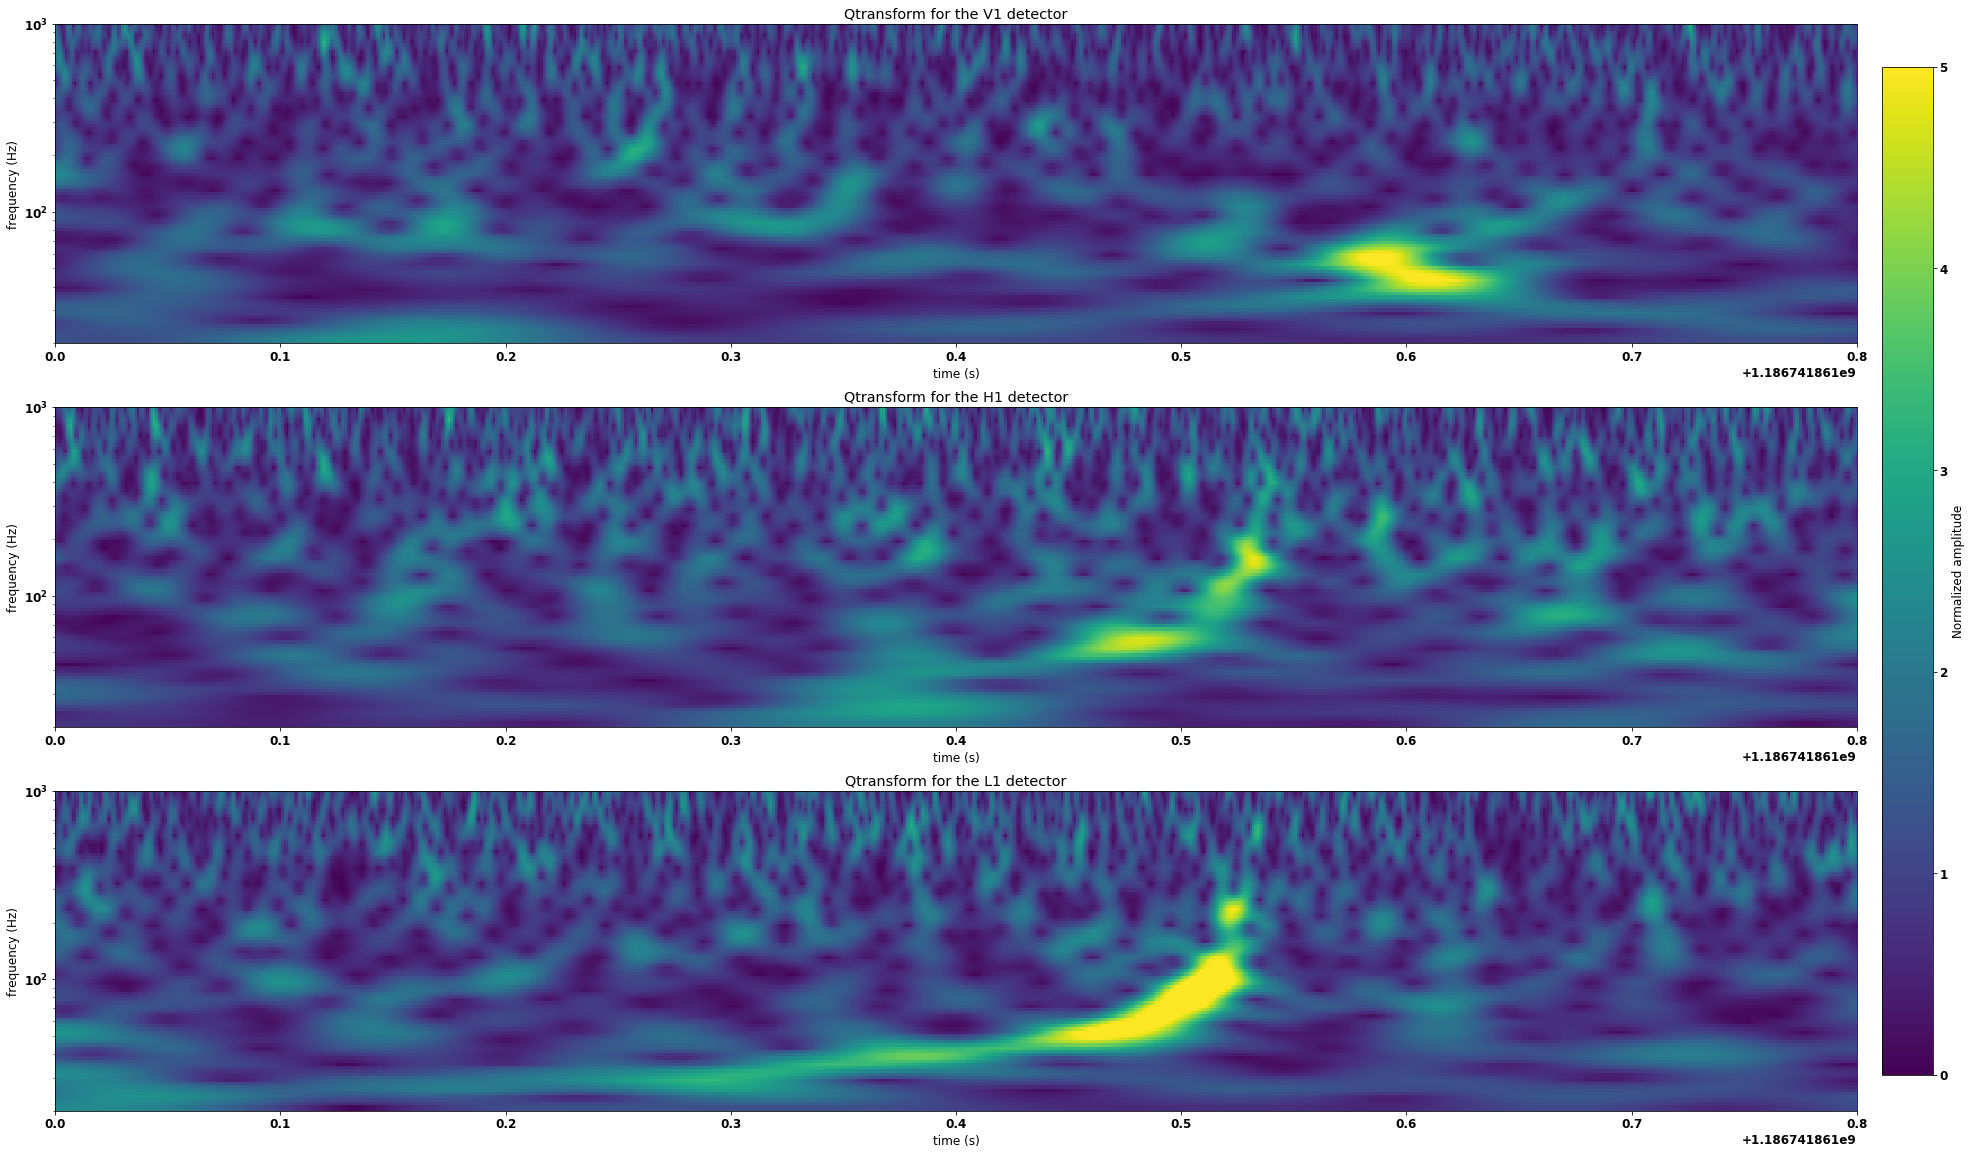

In [14]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 12}

plt.rc('font', **font)


f, ax=plt.subplots(nrows=3, ncols=1, figsize=(35,20))
f.subplots_adjust(right=0.84)
j=0
for i in whitened:
    zoom=whitened[i].time_slice(m.time-5, m.time+5)
    times, freqs, power = zoom.qtransform(0.001, logfsteps=100 , qrange=(10,10), frange=(20,1000))
    im=ax[j].pcolormesh(times, freqs, power**0.5, vmin=0, vmax=5)
    ax[j].set_xlim(m.time-0.5, m.time+0.3)
    ax[j].set_title("Qtransform for the %s detector" %i)
    ax[j].set_yscale('log')
    ax[j].set_xlabel("time (s)")
    ax[j].set_ylabel("frequency (Hz)")
    ax[j].set_ylim(0,1000)
    j+=1
j=2
cbar_ax = f.add_axes([0.85, 0.15, 0.02, 0.7])
cbar=f.colorbar(im, cax=cbar_ax)
#can eventually set a sort of title for the data in the colorbar
cbar.ax.set_ylabel("Normalized amplitude")

Now we will look at the search for a given signal in the data. This is done by the use of matched filtering. Normally, matched filtering is the best methd for gaussian noise. It is not really the case here. Nevertheless, this method works rather well.

The first step is to **precondition the data**. This enables to get rid of the low frequency noises which can lead to numerical artifacts and thus false signals. The data can eventually be resampled in order to have a better sight if the high frequency content is not important. 

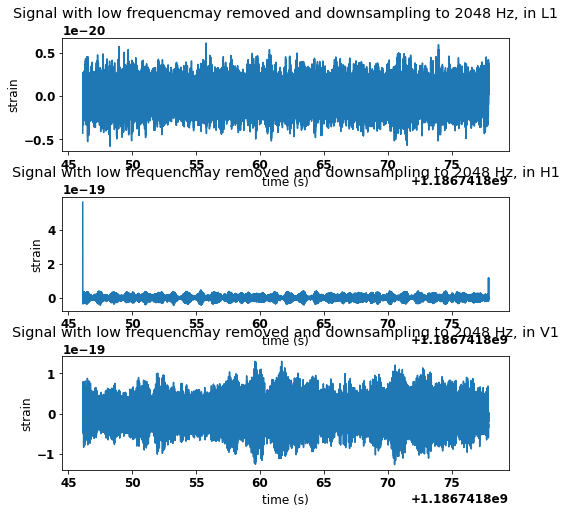

In [15]:
from pycbc.filter import resample_to_delta_t, highpass
from pycbc.psd import interpolate, inverse_spectrum_truncation
import matplotlib.pyplot as plt

detec=['L1','H1', 'V1']
datas={}
psd={}


f=plt.figure(figsize=(8,3))
ax=f.subplots(nrows=3)
f.subplots_adjust( bottom=19, top=21, wspace= 0.4, hspace=0.4)
j=0



for dat in detec:
    ts=m.strain(dat).highpass_fir(15,512)
    datas[dat]= resample_to_delta_t(ts, 1.0/2048)
    ax[j].plot(datas[dat].sample_times, datas[dat])
    ax[j].set_xlabel("time (s)")
    ax[j].set_ylabel("strain")
    ax[j].set_title("Signal with low frequencmay removed and downsampling to 2048 Hz, in %s" %dat, pad=20)
    j+=1

The spike at the boudaries is due to the modification of the data through the use of the bandpass and the refiltering of the data. The is a wrapping of the data that corresponds to the filter and there is a ring of the signal due to the discontinuity at the boarders, which appears at the lenght of the filter.

We can avoid this problem by the removal of the boarders of the filter. We wil thus remove 2 seconds of data at the start and the end of the sequence. 

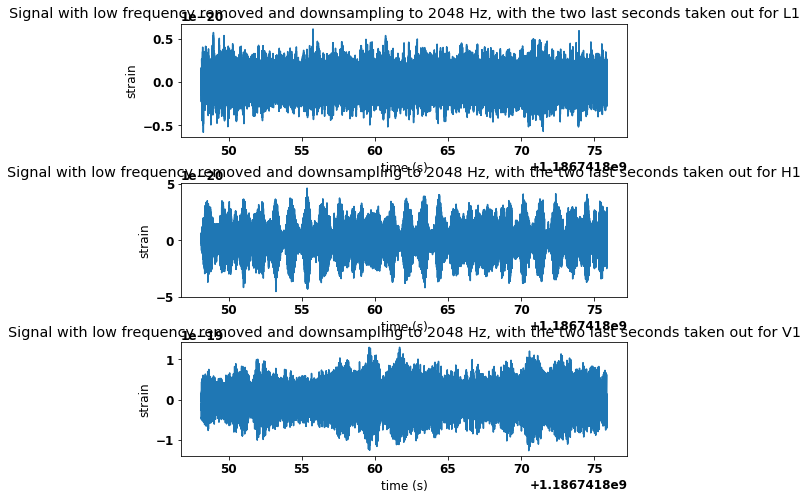

In [16]:
f=plt.figure(figsize=(8,3))
ax=f.subplots(nrows=3)
f.subplots_adjust( bottom=18, top=20, wspace= 0.4, hspace=0.4)
j=0

for dat in detec:
    datas[dat]=datas[dat].crop(2,2)
    ax[j].plot(datas[dat].sample_times, datas[dat])
    ax[j].set_xlabel("time (s)")
    ax[j].set_ylabel("strain")
    ax[j].set_title("Signal with low frequency removed and downsampling to 2048 Hz, with the two last seconds taken out for %s" %dat)
    j+=1

We can then estimate the psd of the data. This is done by the use of a 2s sample. It is, once more, done with the Welsh technique.  

Text(0.5,1,'Estimate of the psd of the data')

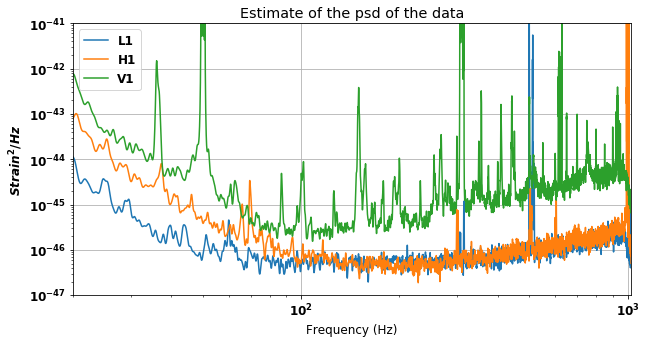

In [17]:
plt.figure(figsize=(10,5))
for dat in detec:
    p = datas[dat].psd(2)
    p = interpolate(p, datas[dat].delta_f)
    p = inverse_spectrum_truncation(p, 2 * datas[dat].sample_rate, low_frequency_cutoff=15.0)
    psd[dat] = p
    plt.plot(psd[dat].sample_frequencies, psd[dat], label=dat)

plt.yscale('log')
plt.xscale('log')
plt.ylim(1e-47, 1e-41)
plt.xlim(20, 1024)
plt.ylabel('$Strain^2 / Hz$')
plt.xlabel('Frequency (Hz)')
plt.grid()
plt.legend()
plt.title("Estimate of the psd of the data")

In order to be able to fit a model to the data, we need to be able to have a tamplate. For this purpose, we first assue that the black holes at the origin of the phenomea are not spinning and have equal masses. Another ethod is to use a minimum likelihood estimate found on the LIGO data. 

/home/justin/.local/lib/python2.7/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0.5,1,'Model of the waveform used')

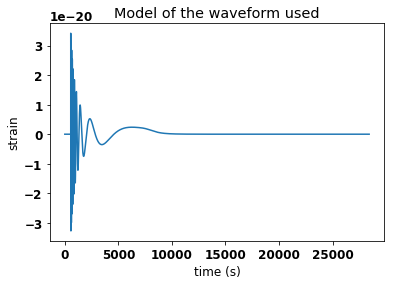

In [18]:
#in this case, the waveform is taken in the time domain
from pycbc.waveform import get_fd_waveform
#firt we calculate the mass of the two black holes in the detector frame
cmass = (m.median1d("mass1") + m.median1d("mass2")) / 2.0  # This is in the source frame
cmass *= (1 + m.median1d("redshift")) # apply redshift to get to the detector frame

hp, hf = get_fd_waveform(approximant="IMRPhenomD",
                         mass1=cmass, mass2=cmass,
                         f_lower=20.0, delta_f=datas[dat].delta_f)
hp.resize(len(psd[dat]))
template=hp.cyclic_time_shift(hp.start_time)
plt.plot(template)
#plt.xlim(5000,10000)
plt.ylabel("strain")
plt.xlabel("time (s)")
plt.title("Model of the waveform used")

We found a signal at 1186741861.5258789s with a SNR of 12.5377356 in the L1 detector
We found a signal at 1186741861.5341797s with a SNR of 9.1938089 in the H1 detector
We found a signal at 1186741868.5659180s with a SNR of 5.3442750 in the V1 detector


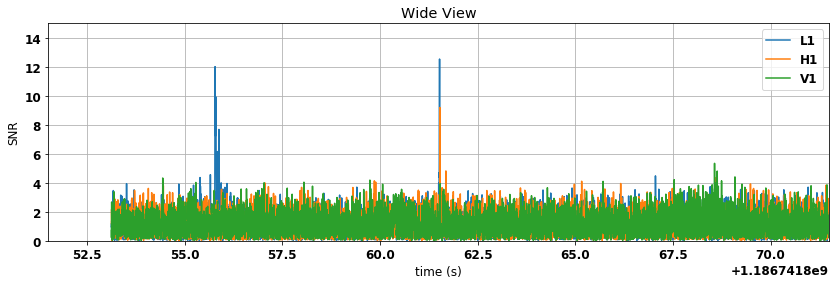

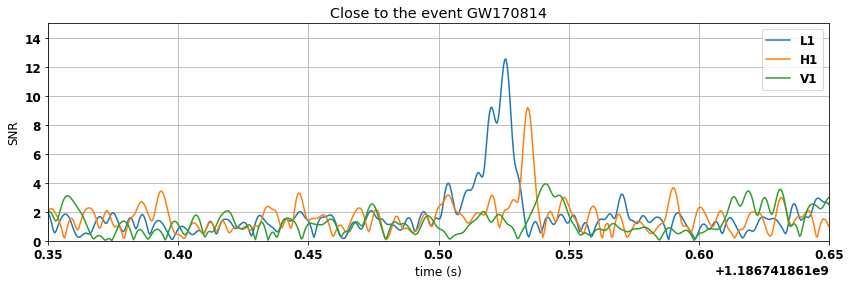

In [19]:
from pycbc.filter import matched_filter
import numpy
snr={}
peaks={}
snrp={}
times={}

for i in detec:
    snr[i] = matched_filter(hp, datas[i], psd=psd[i], low_frequency_cutoff=20)
    snr[i] = snr[i].crop(5, 4) 

for w, title in [(10, 'Wide View'), (.15, 'Close to the event GW170814')]:
    plt.figure(figsize=(14,4))
    for i in detec:
        plt.plot(snr[i].sample_times, abs(snr[i]), label=i)
        if(w==10):
            peaks[i]=abs(snr[i]).numpy().argmax()
            snrp[i]=snr[i][peaks[i]]
            times[i]=snr[i].sample_times[peaks[i]]
            print("We found a signal at %.7fs with a SNR of %.7f in the %s detector" %(times[i], abs(snrp[i]), i))
        
    plt.legend(loc='best')
    plt.title(title)
    plt.grid()
    plt.xlim(m.time-w, m.time+w)
    plt.ylim(0,15)
    plt.xlabel("time (s)")
    plt.ylabel("SNR")

The presence of the peaks at other places than around the event itself is the proof that there are other transient signals that are detected in the detector. Those are artificial and are not due to physical causes. 

In order to see how well our data and the tamplate fit togheter, we use a **chi square test**. (The method is decribed in the paper: *chi square test*). The idea is to separate the template into p different number of bins and test how much each contributes in the SNR of the signal.
We use the formula:

$
\chi^2 = \sum^p_{i=0} (\rho_i - \rho / p)^2
$

p, the number of bins is arbitrary chosen in principle but, in practice, we tune it empirically.

The expression has 2p-p degrees of freedom because we hae a complex SNR, representing the two orthogonal phases that the signal can have. The sum of all the bins must also be the total SNR. This leads to an extra contribution. We ca also normalize the statistic by a division of the chi-square by the number of degrees of freedom.

The value of the normalized statistics should then normally be close to one when the signal and the template match well (hence we have the signal and gaussian noise) and higher when there is no matching, hence when there is only gaussian noise. 

Text(0.5,1,'Normalized chi square statistic')

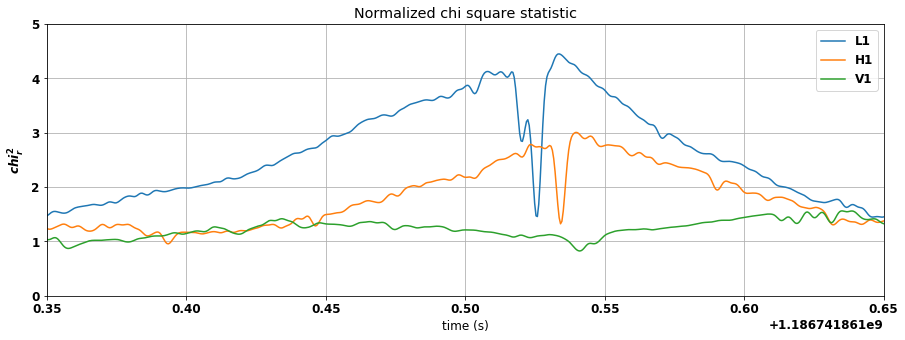

In [20]:
from pycbc.vetoes import power_chisq
chi={}
for i in detec:
    p=26
    chi[i]=power_chisq(hp,datas[i], p, psd[i], low_frequency_cutoff=20.0)
    chi[i]=chi[i].crop(5,4)
    dof=p*2-2
    chi[i]/=dof #normalization of the statistic

plt.figure(figsize=(15,5))
for i in detec:
    plt.plot(chi[i].sample_times, chi[i], label=i)
plt.legend(loc="best")
plt.grid()
plt.xlim(m.time-0.15, m.time+0.15)
plt.ylim(0,5)
plt.ylabel('$chi^2_r$')
plt.xlabel('time (s)')
plt.title("Normalized chi square statistic")

We see the presence of a dip in the value of the chi square at the time corresponding to the signal. This means that the data and the template allign at this time. In addition, the value of chi square decreae when the template comes close to the time of the wave. This is because there is a start of allignement which is optimal at the time of the event. In addition, there is first an increase of the value of the chi squre. That comes from the gliding of the template against the sigal.

**down-weight the SNR at times thatt do not fit our signal** can help have a better view of the place where he peak is present in the SNR. What is done is to decrease the weight of the effect of the artifacts. The times that are effectively less effective after the process are those where the signal neither apprears as gaussin noise or our template with gaussian noise added. In oractice, we combine the SNR series and the chi square series, definig the statistic:

$\hat{\rho} = \frac{\rho}{ [1 + (\chi^2_r)^3]^{1/6}}$ where $\chi^2 > 1$, otherwise $\rho$

*more info see paper "reweight"*

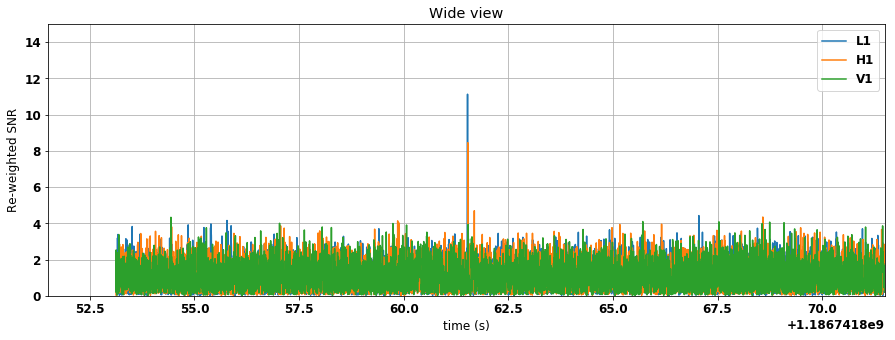

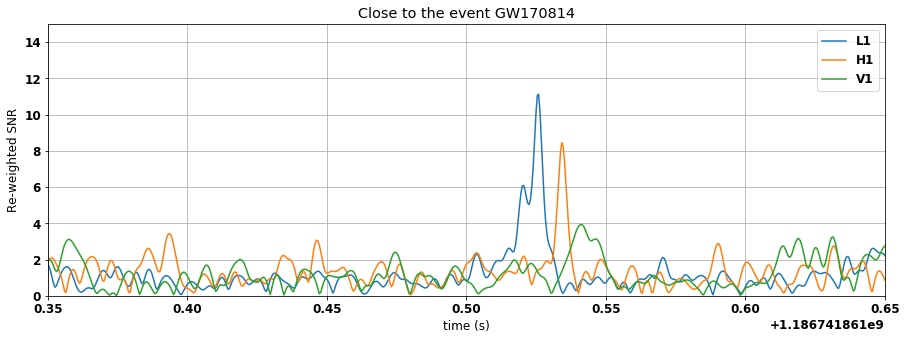

In [21]:
from pycbc.events.ranking import newsnr
#newsnr correponds to the rho hat defined above and can thus be foud directly here with a build in function
nsnr = {ifo:newsnr(abs(snr[ifo]), chi[ifo]) for ifo in detec}

#we represnt the new SNR time series
for w, title in [(10, "Wide view"), (0.15, "Close to the event GW170814")]:
    plt.figure(figsize=(15,5))
    for i in detec:
        plt.plot(snr[i].sample_times,  nsnr[i], label=i)
    plt.legend(loc="best")
    plt.title(title)
    plt.grid()
    plt.xlim(m.time-w, m.time+w)
    plt.ylim(0,15)
    plt.xlabel("time (s)")
    plt.ylabel("Re-weighted SNR")

We see that the reweighting of the data enables to have the disapearance of the peaks that where present before in the SNR. The high statistic values, different from those due to the matching of the filter and the rest of the data, have thus been taken out of the series thannks to the reweighting. 

We have then the possibility to **calculate the backgroud and significance** of the peak int he Virgo SNR time series (reweighted). 

In order to se that, we first look at the time regions where one can expect the presnce of a peak relative to the LIGO peaks in the data. These regions are constrained by the use of the property that the delay between the signals cannot be smaller than the time needed for the light to travel frome one detector to the other. 

The following step is yto look at the SNR peak for the window around the LIGO determined during the previous step. This is the "on source" signal.

In order to have the significance of the on-source signal, we compare it with the background. Indeed, we calculate how likely it is to have a peak at this height or even highe only with the background. This is done by calculating the probability empricically, based on the off-source signal, hence the portions of the signal that ae not in the window of time defined previsously. In oredr to avoid the presence of theany bias, it is important that the backgroud and the experiment are done in the same way, as well as the calculation. 

In order to perform this kind of calculation, we have the possibility to use the build in functions of pycbc, such as pycbc.detecor.Dector, that enables to calculate automatically the time delay between the detectors

Virgo Peak has a statistic value of 3.93682333761


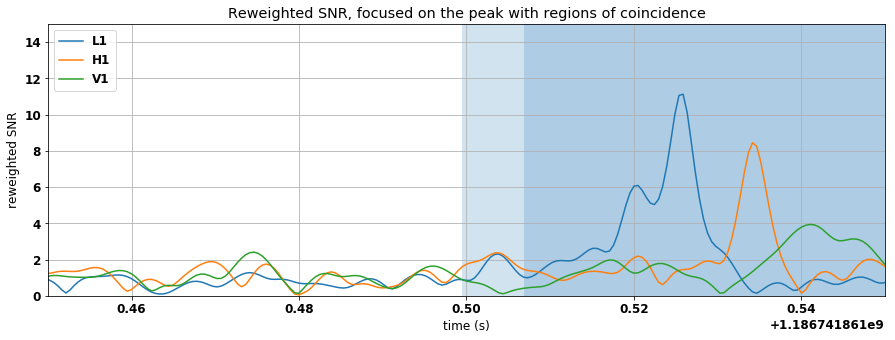

In [22]:
import numpy as np
from pycbc.detector import Detector
#time of flight of the information between the Virgo detector and each of the LIGO detector
d= Detector("V1")
time_flight={}
time_flight["H1"]=d.light_travel_time_to_detector(Detector("H1"))
time_flight["L1"]=d.light_travel_time_to_detector(Detector("L1"))
#we record the time of the peaks in the LIGO detectors
ptime={}
plt.figure(figsize=(15,5))

for i in detec:
    #we shade the region around each LIGO peak where we could find a Virgo peak that matches a GW signal
    if i is not "V1":
        ptime[i]= snr[i].sample_times[nsnr[i].argmax()]
        plt.axvspan(ptime[i]-time_flight[i], ptime[i]+time_flight[i], alpha=0.2, lw=10)
    
    plt.plot(snr[i].sample_times, nsnr[i], label=i)

#calculation of the interval of time where the Virgo peak can be located, based on the time of flight
#theses times must be converted into indices corresponding to the width and number os samples
st=ptime["H1"]-time_flight["H1"]
end=ptime["L1"]+time_flight["L1"]
wind_size= int((end-st)*snr["V1"].sample_rate)
start_index=int((st-snr["V1"].start_time)*snr["V1"].sample_rate)
end_index= start_index+wind_size

#Calculation of the on source reweighted peak
onsource=nsnr["V1"][start_index:end_index].max()


plt.legend(loc="best")
plt.grid()
plt.xlim(m.time-0.05, m.time+0.05)
plt.ylim(0,15)
plt.xlabel("time (s)")
plt.ylabel("reweighted SNR")
plt.title("Reweighted SNR, focused on the peak with regions of coincidence")

print('Virgo Peak has a statistic value of {}'.format(onsource))

The darkest region in the plot above is the one that is compatible with a GW that would be detected in both detectors

In the cell above, the on-source peak statistical value has been calculated. Now, we need to calculate the background peak values. As sais previsouly, this is done by the use of the off-source part. Indeed, we will parcour these section and cut them in series with the same size as the on-source data and find the maximum in each of them. Then, we fin the probability that the background gives a peak at the height of the one we have in tne on-source data.

The p-value that we will be looking for will be the number of samples in the background that have a value equal or higher than the onsource value when divided by the number of values (normalization). We can than find the significance of the on-souce vigro peak by comparing with the onsource values that have been found.

The p-value associated with the GW170814 peak is 0.019512195122


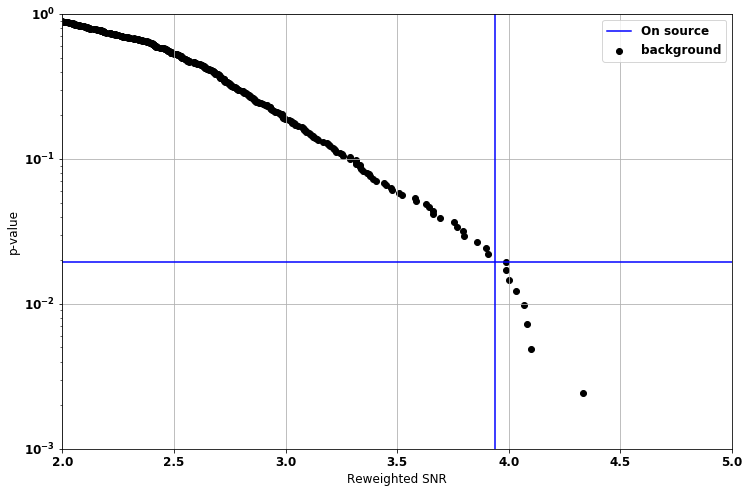

In [23]:
peaks=[]
i=0
#we walk through the data in section of a given lenght
while i+wind_size<len(nsnr["V1"]):
    p=nsnr["V1"][i:i+wind_size].max()
    peaks.append(p)
    i+=wind_size
    #we need to skip the on source data
    if abs(i-start_index)<wind_size:
        i +=wind_size*2
peaks= np.array(peaks) #conversion to a numpy array in order to have access to the math properties
pcurve=np.arange(1, len(peaks)+1)[::-1]/float(len(peaks))
peaks.sort()
pvalue=(peaks>onsource).sum()/float(len(peaks))
plt.figure(figsize=(12,8))
plt.scatter(peaks, pcurve, label='background', color='black')
plt.axvline(onsource, label='On source', color='blue')
plt.axhline(pvalue, color='blue')
plt.legend(loc="best")
plt.yscale('log')
plt.grid()
plt.ylim(1e-3,1e0)
plt.ylabel("p-value")
plt.xlabel("Reweighted SNR")
plt.xlim(2,5)

print("The p-value associated with the GW170814 peak is {}".format(pvalue))

In [1]:
from pycbc.filter import sigma

peak={}
ptimes={}
dt={}
aligned={}
snrp={}
whitened_data={}
tapered={}
whitened_template={}

f=plt.figure(figsize=(20,5))
ax=f.subplots(nrows=3)
f.subplots_adjust( bottom=18, top=20, wspace= 0.4, hspace=0.4)
j=0

for i in detec:
    peak[i]=abs(nsnr[i]).argmax()
    snrp[i]=nsnr[i][peak[i]]
    ptimes[i]=snr[i].sample_times[nsnr[i].argmax()]
    #translation of the template to the correct time
    dt[i]=ptimes[i]-datas[i].start_time
    aligned[i]=template.cyclic_time_shift(dt[i])
    #rescaling of the tamplate so that it has a SNR od 1 with data
    aligned[i]/=sigma(aligned[i], psd=psd[i], low_frequency_cutoff=20.0)
    #scaling of template at amplitude and phase of the peak value
    aligned[i]=(aligned[i]*snrp[i]).to_timeseries()
    aligned[i].start_time=datas[i].start_time
    whitened_data[i]=(datas[i].to_frequencyseries()/psd[i]**0.5).to_timeseries()
    #smoothing of the templateto avoid a transient
    tapered[i]=aligned[i].highpass_fir(30,512, remove_corrupted=False)
    whitened_template[i]=(tapered[i].to_frequencyseries()/psd[i]**0.5).to_timeseries()
    #filetering of the frequencies that are kept (only the interesting ones in the correct range)
    whitened_data[i]=whitened_data[i].highpass_fir(30.,512).lowpass_fir(300,512)
    whitened_template[i]=whitened_template[i].highpass_fir(30.,512).lowpass_fir(300,512)
    
    
    if i=='V1':
        ax[j].set_xlim(54.2+1.1867418e9,54.6+1.1867418e9)
        ax[j].plot(whitened_data[i].sample_times, whitened_data[i], label="Data")
        ax[j].plot(whitened_template[i].sample_times, whitened_template[i], label="Template")
    else:
        #selection of the time around the event
        whitened_data[i]=whitened_data[i].time_slice(m.time-0.2, m.time+0.2)
        whitened_template[i]=whitened_template[i].time_slice(m.time-0.2, m.time+0.2)
        ax[j].plot(whitened_data[i].sample_times, whitened_data[i], label="Data")
        ax[j].plot(whitened_template[i].sample_times, whitened_template[i], label="Template")
    ax[j].legend()
    ax[j].set_title("Data and template superposed for %s" %i)
    j+=1

NameError: name 'plt' is not defined

We see that this easy way to find the template that enables to fit very well the L1 detector but not the others. This comes mainly from the fact that we use a very simple model here. Indeed, in the "real" analysis, there is the use of a fine tuning of the parameters in the templates in order to have the event. Therefore, the templates are selected and make with an optimization that enables to constraint much more the waveform. On the other hand, here, we use only one template, made very simply, with the assumption of the black holes with the same masse and a zero spin. It seems logic that the solution cannot fit perfectly the data. The paper published after detection, done with the complete analysis gives masses of 30.5 and 25.3 solar masses. The masses are thus not equal, which means that the assumptions made do not allign with the real observation. 

Nw we try to make the template with all the parameters that are given in the LIGO-Virgo analysis, hence the correct masses, distance, position, spins, etc.

Text(0.5,1,'Model of the waveform used')

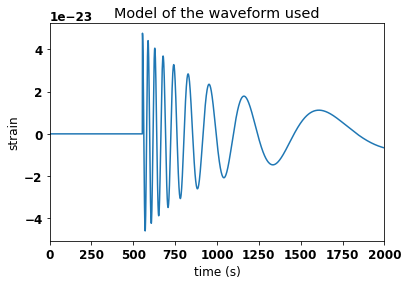

In [25]:
from pycbc.waveform import get_fd_waveform
#we try a waveform that enables to have a bette waveform. Therefore, we include the masses that have been found in the paper

hp, hf = get_fd_waveform(approximant="IMRPhenomD",
                         mass1=30.5, mass2=25.3, spin1z=-0.56879753, spin2z=0.13079314, distance=540, inclination=0.6,
                         f_lower=20.0, delta_f=datas[dat].delta_f, f_final=739.0645)
hp.resize(len(psd[dat]))
template=hp.cyclic_time_shift(hp.start_time)
plt.plot(template)
plt.xlim(0,2000)
plt.ylabel("strain")
plt.xlabel("time (s)")
plt.title("Model of the waveform used")

We found a signal at 1186741861.5244141s with a SNR of 13.0505848 in the L1 detector
We found a signal at 1186741861.5327148s with a SNR of 9.2115963 in the H1 detector
We found a signal at 1186741868.5644531s with a SNR of 5.4803894 in the V1 detector


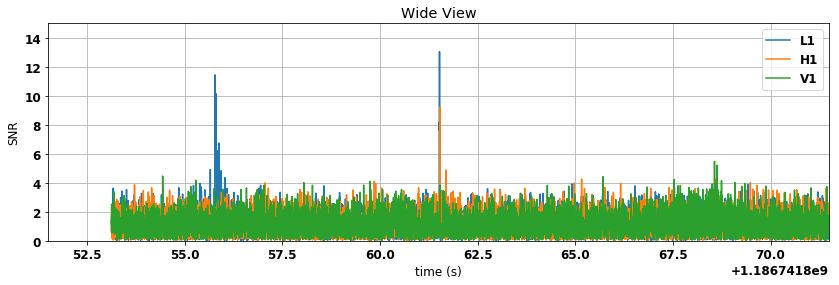

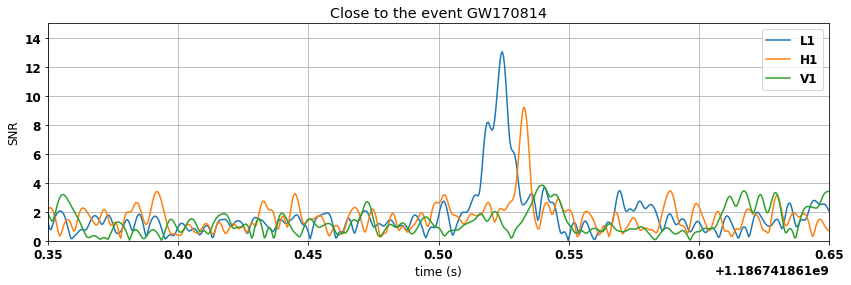

In [26]:
from pycbc.filter import matched_filter
snr={}
peaks={}
snrp={}
times={}

for i in detec:
    snr[i] = matched_filter(template, datas[i], psd=psd[i], low_frequency_cutoff=20)
    snr[i] = snr[i].crop(5, 4) 

for w, title in [(10, 'Wide View'), (.15, 'Close to the event GW170814')]:
    plt.figure(figsize=(14,4))
    for i in detec:
        plt.plot(snr[i].sample_times, abs(snr[i]), label=i)
        if(w==10):
            peaks[i]=abs(snr[i]).numpy().argmax()
            snrp[i]=snr[i][peaks[i]]
            times[i]=snr[i].sample_times[peaks[i]]
            print("We found a signal at %.7fs with a SNR of %.7f in the %s detector" %(times[i], abs(snrp[i]), i))
    plt.legend(loc='best')
    plt.title(title)
    plt.grid()
    plt.xlim(m.time-w, m.time+w)
    plt.ylim(0,15)
    plt.xlabel("time (s)")
    plt.ylabel("SNR")

Text(0.5,1,'Normalized chi square statistic')

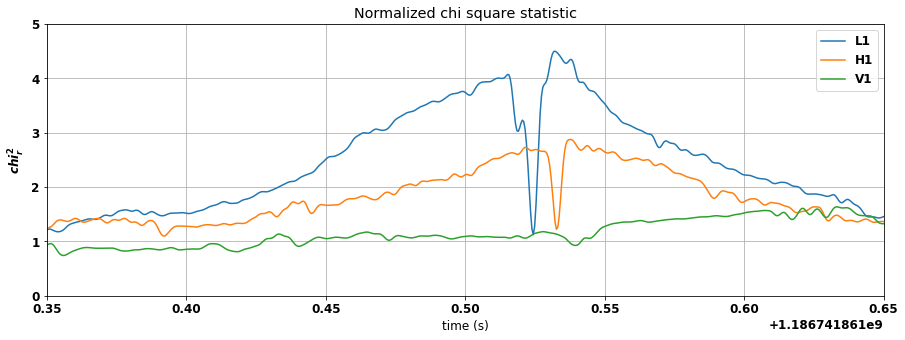

In [27]:
from pycbc.vetoes import power_chisq
chi={}
for i in detec:
    p=26
    chi[i]=power_chisq(hp,datas[i], p, psd[i], low_frequency_cutoff=20.0)
    chi[i]=chi[i].crop(5,4)
    dof=p*2-2
    chi[i]/=dof #normalization of the statistic

plt.figure(figsize=(15,5))
for i in detec:
    plt.plot(chi[i].sample_times, chi[i], label=i)
plt.legend(loc="best")
plt.grid()
plt.xlim(m.time-0.15, m.time+0.15)
plt.ylim(0,5)
plt.ylabel('$chi^2_r$')
plt.xlabel('time (s)')
plt.title("Normalized chi square statistic")

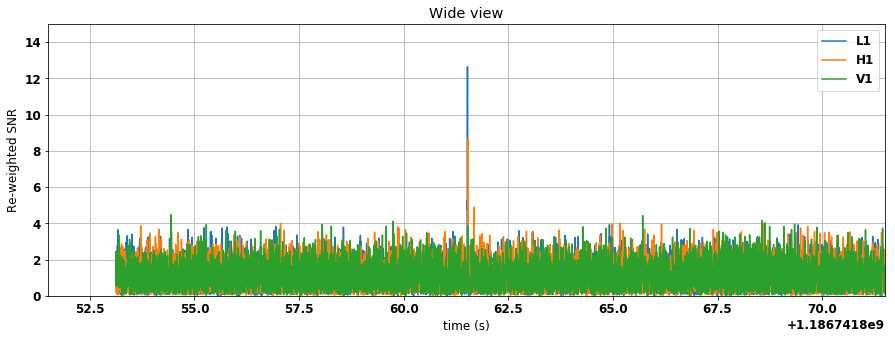

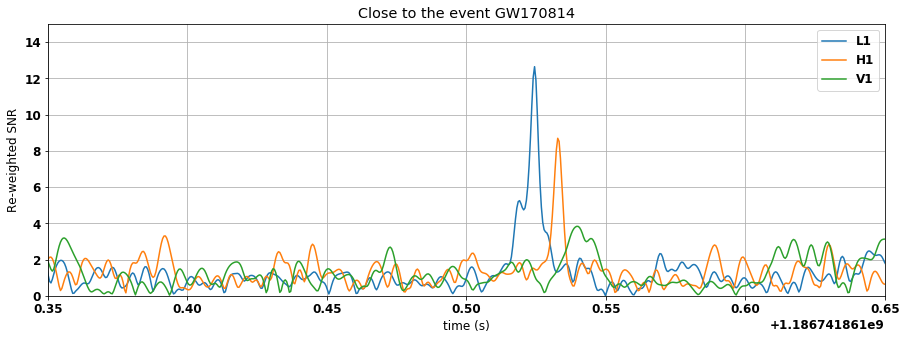

In [28]:
from pycbc.events.ranking import newsnr
#newsnr correponds to the rho hat defined above and can thus be foud directly here with a build in function
nsnr = {ifo:newsnr(abs(snr[ifo]), chi[ifo]) for ifo in detec}

#we represnt the new SNR time series
for w, title in [(10, "Wide view"), (0.15, "Close to the event GW170814")]:
    plt.figure(figsize=(15,5))
    for i in detec:
        plt.plot(snr[i].sample_times,  nsnr[i], label=i)
    plt.legend(loc="best")
    plt.title(title)
    plt.grid()
    plt.xlim(m.time-w, m.time+w)
    plt.ylim(0,15)
    plt.xlabel("time (s)")
    plt.ylabel("Re-weighted SNR")

Virgo Peak has a statistic value of 3.83457046168


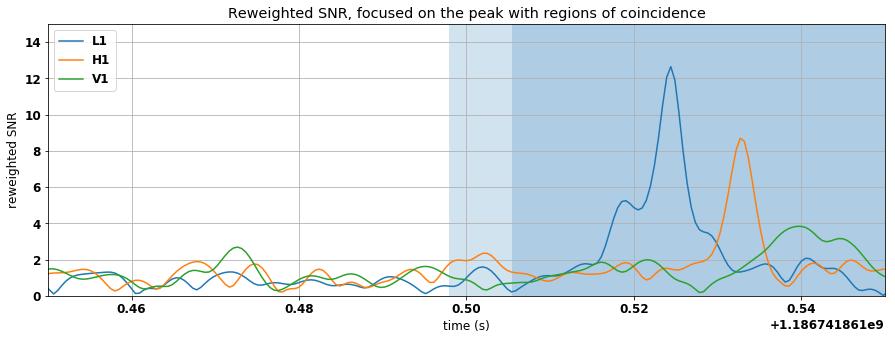

In [29]:
import numpy as np
from pycbc.detector import Detector
#time of flight of the information between the Virgo detector and each of the LIGO detector
d= Detector("V1")
time_flight={}
time_flight["H1"]=d.light_travel_time_to_detector(Detector("H1"))
time_flight["L1"]=d.light_travel_time_to_detector(Detector("L1"))
#we record the time of the peaks in the LIGO detectors
ptime={}
plt.figure(figsize=(15,5))

for i in detec:
    #we shade the region around each LIGO peak where we could find a Virgo peak that matches a GW signal
    if i is not "V1":
        ptime[i]= snr[i].sample_times[nsnr[i].argmax()]
        plt.axvspan(ptime[i]-time_flight[i], ptime[i]+time_flight[i], alpha=0.2, lw=10)
    
    plt.plot(snr[i].sample_times, nsnr[i], label=i)

#calculation of the interval of time where the Virgo peak can be located, based on the time of flight
#theses times must be converted into indices corresponding to the width and number os samples
st=ptime["H1"]-time_flight["H1"]
end=ptime["L1"]+time_flight["L1"]
wind_size= int((end-st)*snr["V1"].sample_rate)
start_index=int((st-snr["V1"].start_time)*snr["V1"].sample_rate)
end_index= start_index+wind_size

#Calculation of the on source reweighted peak
onsource=nsnr["V1"][start_index:end_index].max()


plt.legend(loc="best")
plt.grid()
plt.xlim(m.time-0.05, m.time+0.05)
plt.ylim(0,15)
plt.xlabel("time (s)")
plt.ylabel("reweighted SNR")
plt.title("Reweighted SNR, focused on the peak with regions of coincidence")

print('Virgo Peak has a statistic value of {}'.format(onsource))

The p-value associated with the GW170814 peak is 0.0268292682927


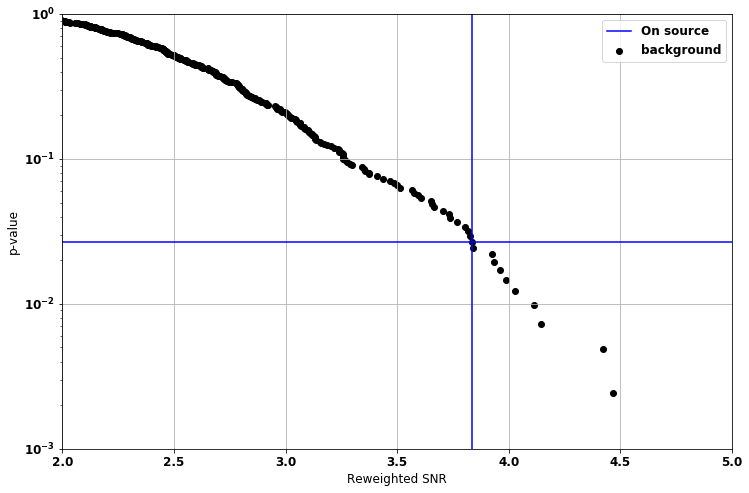

In [30]:
peaks=[]
i=0
#we walk through the data in section of a given lenght
while i+wind_size<len(nsnr["V1"]):
    p=nsnr["V1"][i:i+wind_size].max()
    peaks.append(p)
    i+=wind_size
    #we need to skip the on source data
    if abs(i-start_index)<wind_size:
        i +=wind_size*2
peaks= np.array(peaks) #conversion to a numpy array in order to have access to the math properties
pcurve=np.arange(1, len(peaks)+1)[::-1]/float(len(peaks))
peaks.sort()
pvalue=(peaks>onsource).sum()/float(len(peaks))
plt.figure(figsize=(12,8))
plt.scatter(peaks, pcurve, label='background', color='black')
plt.axvline(onsource, label='On source', color='blue')
plt.axhline(pvalue, color='blue')
plt.legend(loc="best")
plt.yscale('log')
plt.grid()
plt.ylim(1e-3,1e0)
plt.ylabel("p-value")
plt.xlabel("Reweighted SNR")
plt.xlim(2,5)

print("The p-value associated with the GW170814 peak is {}".format(pvalue))

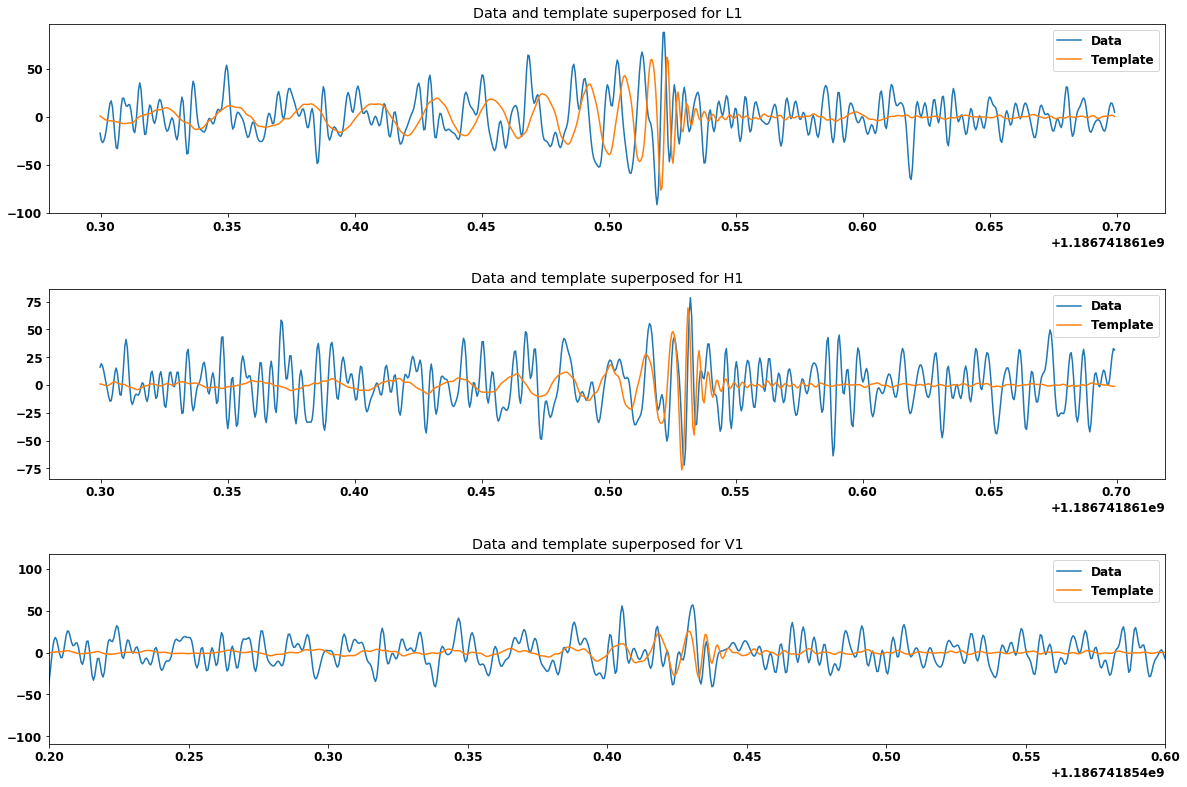

In [31]:
from pycbc.filter import sigma

peak={}
ptimes={}
dt={}
aligned={}
snrp={}
whitened_data={}
tapered={}
whitened_template={}m

f=plt.figure(figsize=(20,5))
ax=f.subplots(nrows=3)
f.subplots_adjust( bottom=18, top=20, wspace= 0.4, hspace=0.4)
j=0

for i in detec:
    peak[i]=abs(nsnr[i]).argmax()
    snrp[i]=nsnr[i][peak[i]]
    ptimes[i]=snr[i].sample_times[nsnr[i].argmax()]
    #translation of the template to the correct time
    dt[i]=ptimes[i]-datas[i].start_time
    aligned[i]=template.cyclic_time_shift(dt[i])
    #rescaling of the tamplate so that it has a SNR od 1 with data
    aligned[i]/=sigma(aligned[i], psd=psd[i], low_frequency_cutoff=20.0)
    #scaling of template at amplitude and phase of the peak value
    aligned[i]=(aligned[i]*snrp[i]).to_timeseries()
    aligned[i].start_time=datas[i].start_time
    whitened_data[i]=(datas[i].to_frequencyseries()/psd[i]**0.5).to_timeseries()
    #smoothing of the templateto avoid a transient
    tapered[i]=aligned[i].highpass_fir(30,512, remove_corrupted=False)
    whitened_template[i]=(tapered[i].to_frequencyseries()/psd[i]**0.5).to_timeseries()
    #filetering of the frequencies that are kept (only the interesting ones in the correct range)
    whitened_data[i]=whitened_data[i].highpass_fir(30.,512).lowpass_fir(300,512)
    whitened_template[i]=whitened_template[i].highpass_fir(30.,512).lowpass_fir(300,512)
    
    
    if i=='V1':
        ax[j].set_xlim(54.2+1.1867418e9,54.6+1.1867418e9)
        ax[j].plot(whitened_data[i].sample_times, whitened_data[i], label="Data")
        ax[j].plot(whitened_template[i].sample_times, whitened_template[i], label="Template")
    else:
        #selection of the time around the event
        whitened_data[i]=whitened_data[i].time_slice(m.time-0.2, m.time+0.2)
        whitened_template[i]=whitened_template[i].time_slice(m.time-0.2, m.time+0.2)
        ax[j].plot(whitened_data[i].sample_times, whitened_data[i], label="Data")
        ax[j].plot(whitened_template[i].sample_times, whitened_template[i], label="Template")
    ax[j].legend()
    ax[j].set_title("Data and template superposed for %s" %i)
    j+=1

With the parameters more adapted to the data and the event, the SNR praks have indeed increased and correspond better to the data that has been found here. 

Now we try to find the best fit parameter by a minimzation of the loglikelihood

Text(0.5,1,'Data from the Livingston detector')

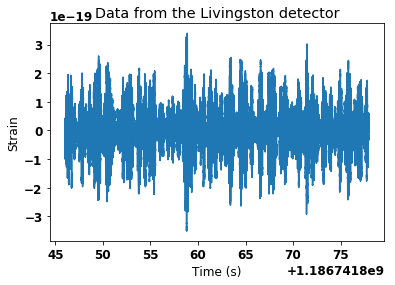

In [32]:
%matplotlib inline 

#first we need to set bigger characters for the titles, labels and thicks.
import matplotlib
import matplotlib.pyplot as plt
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 12}

matplotlib.rc('font', **font)
from pycbc.catalog import Merger
from pycbc.filter import resample_to_delta_t, highpass

merger = Merger("GW170814")

# Get the data from the Livingston detector
strain = merger.strain('L1')

# Remove the low frequency content and downsample the data to 20/2048).crop(2, 2)

plt.plot(strain.sample_times, strain)
plt.xlabel('Time (s)')
plt.ylabel("Strain")
plt.title("Data from the Livingston detector")

Text(0.5,1,'Power spectral density for the Livinsgton detector')

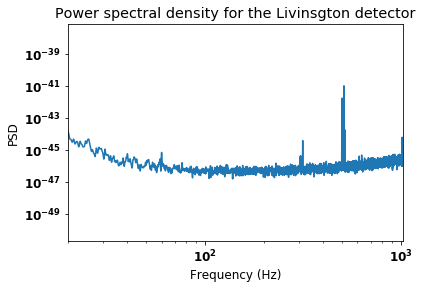

In [33]:
f_lower = 20.
f_upper = 1024.

import numpy as np
from pycbc.psd import interpolate, inverse_spectrum_truncation

psd = strain.psd(4)
psd = interpolate(psd, strain.delta_f)

psd = inverse_spectrum_truncation(psd, 4 * strain.sample_rate)

fs = psd.delta_f * np.arange(psd.data.size)

plt.loglog(fs, psd)
plt.xlim(f_lower, f_upper)
plt.xlabel("Frequency (Hz)")
plt.ylabel("PSD")
plt.title("Power spectral density for the Livinsgton detector")

Text(0.5,1,'Example of waveform')

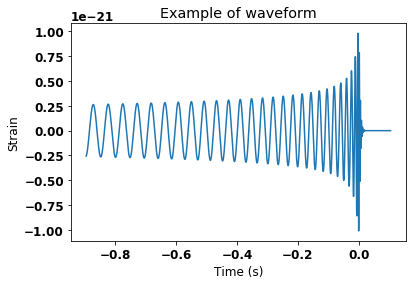

In [34]:
from pycbc import filter
from pycbc.types import Array

from pycbc.waveform import get_td_waveform

m1 = 31 # Solar masses
m2=25.

hp, hc = get_td_waveform(approximant="SEOBNRv4_opt",
                     mass1=m1,
                     mass2=m2, spin1z=-0.56879753, spin2z=0.13079314,distance=540, inclination=0.6,
                     delta_t=strain.delta_t,
                     f_lower=20,f_final=739.0645 )

plt.plot(hp.sample_times, hp)
plt.xlabel('Time (s)')
plt.ylabel("Strain")
plt.title("Example of waveform")

Text(0.5,1,'Whitened data for the Livingtson detector')

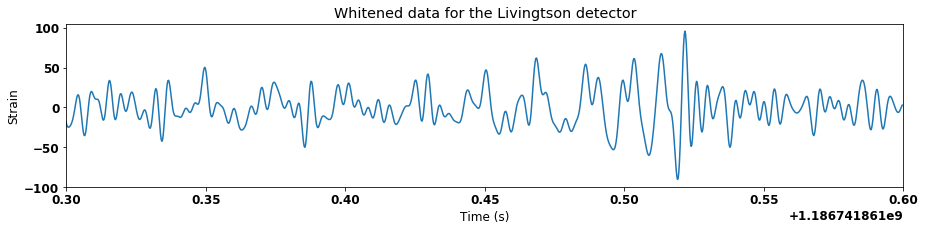

In [35]:
#whitening of the data
white_data = (strain.to_frequencyseries() / psd**0.5).to_timeseries()
white_data = white_data.highpass_fir(30., 512).lowpass_fir(300, 512)
white_data = white_data.time_slice(merger.time-.2, merger.time+.1)

plt.figure(figsize=[15, 3])
plt.plot(white_data.sample_times, white_data)
plt.xlim(merger.time-.2, merger.time+.1)
plt.xlabel('Time (s)')
plt.ylabel("Strain")
plt.title('Whitened data for the Livingtson detector')

In [36]:
def gen_template(theta,
                 delta_t=strain.delta_t,
                 duration=strain.duration,
                 start_time=strain.start_time,
                 f_lower=f_lower):
    
    m1, m2, distance, inclination, time, phase = theta

    hp, hc = get_td_waveform(approximant="SEOBNRv4_opt",
                             mass1=m1,
                             mass2=m2,
                             spin1z=-0.568797,
                             spin2z=0.13079314,
                             distance=distance,
                             inclination=inclination,
                             coa_phase=phase,
                             delta_t=delta_t,
                             f_lower=f_lower)

    # Resize the signal buffer, and shift to the requested time
    hp.resize(int(duration/delta_t))
    hp = hp.cyclic_time_shift(hp.start_time + time - strain.start_time)
    hp.start_time = strain.start_time

    return hp

In [37]:
df = strain.to_frequencyseries()

def loglikelihood(theta, df=df, f_lower=f_lower, f_upper=f_upper):
    N = int(df.duration/df.delta_t)
    
    template = gen_template(theta, delta_t=df.delta_t, f_lower=f_lower)
    hf = template.to_frequencyseries()
    
    kmin, kmax = filter.get_cutoff_indices(f_lower, f_upper, df.delta_f, (N - 1) * 2)

    hh = sum(4.0 * df.delta_f * (hf[kmin:kmax].conj()*hf[kmin:kmax]).real()/psd[kmin:kmax])
    dh = sum(4.0 * df.delta_f * (df[kmin:kmax].conj()*hf[kmin:kmax]).real()/psd[kmin:kmax])
    logl = -0.5*(hh - 2.0*dh)

    return logl

In [38]:
def whiten_trim_template(template, psd=psd):
    tapered = template.highpass_fir(30, 512, remove_corrupted=False)
    white_template = (tapered.to_frequencyseries() / psd**0.5).to_timeseries()
    white_template = white_template.highpass_fir(30, 512).lowpass_fir(300, 512)

    white_template = white_template.time_slice(merger.time-.2, merger.time+.1)
    return white_template

def plot_whitened_strains(strain, template):
    white_data = (strain.to_frequencyseries() / psd**0.5).to_timeseries()

    tapered = template.highpass_fir(30, 512, remove_corrupted=False)
    white_template = (tapered.to_frequencyseries() / psd**0.5).to_timeseries()

    white_data = white_data.highpass_fir(30., 512).lowpass_fir(300, 512)
    white_template = white_template.highpass_fir(30, 512).lowpass_fir(300, 512)

    white_data = white_data.time_slice(merger.time-.2, merger.time+.1)
    white_template = white_template.time_slice(merger.time-.2, merger.time+.1)

    plt.figure(figsize=[15, 3])
    plt.plot(white_data.sample_times, white_data, label="Data")
    plt.plot(white_template.sample_times, white_template, label="Template")
    plt.xlim(merger.time-.2, merger.time+.1)
    plt.legend()

-71.14832259267132


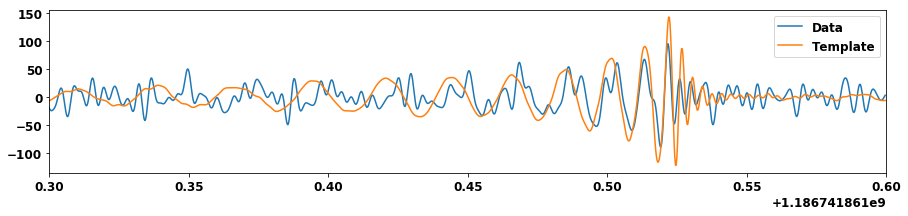

In [39]:
# m1, m2, spin1z, spin2z, distance, inclination, time, phase (trial with fixed spins)
theta0 = [31., 25., 580.,0.6, float(merger.time)+0.025,0]

template0 = gen_template(theta0)
plot_whitened_strains(strain, template0)

print(loglikelihood(theta0))

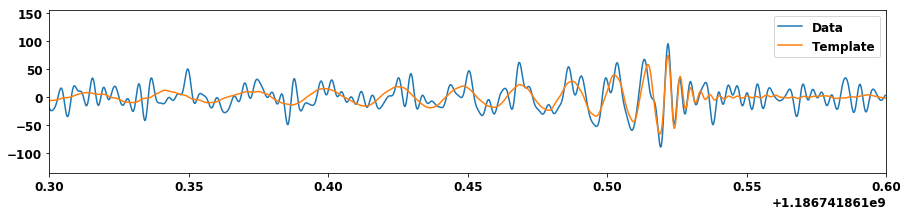

Steps	log(likelihood)
8	85.029


In [40]:
from scipy.optimize import minimize
from IPython.display import display, clear_output

fig, ax = plt.subplots(1, 1, figsize=[15, 3])
Neval = 1

whitened_template = whiten_trim_template(gen_template(theta0))

plt.plot(white_data.sample_times, white_data, label="Data")
line, = plt.plot(whitened_template.sample_times, whitened_template, label="Template")

plt.xlim(merger.time-.2, merger.time+.1)
plt.legend()

def callback(thetai):
    global Neval
    global line
    global fig
    
    template = gen_template(thetai)
    white_template = whiten_trim_template(gen_template(thetai))
    line.set_ydata(white_template)

    clear_output(wait=True)
    display(fig)
    print("Steps\tlog(likelihood)")
    print('{}\t{:.3f}'.format(Neval, loglikelihood(thetai)))
    
    Neval += 1
    
res = minimize(lambda theta: -loglikelihood(theta), theta0, callback=callback, method='powell')
plt.close()

[ 3.11285593e+01  2.50000341e+01  1.30569800e+03 -5.82574474e-05
  1.18674186e+09 -3.74218499e-01]


Text(0.5,1,'Whitened strain and template for the L1 detector')

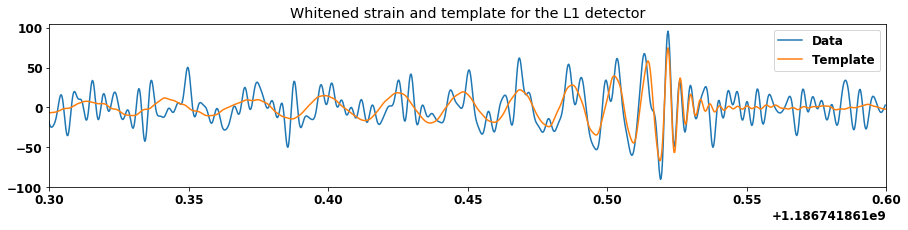

In [41]:
best_fit = res.x
best_fit_template = gen_template(best_fit)
print(best_fit)
plot_whitened_strains(strain, best_fit_template)
plt.title("Whitened strain and template for the L1 detector")

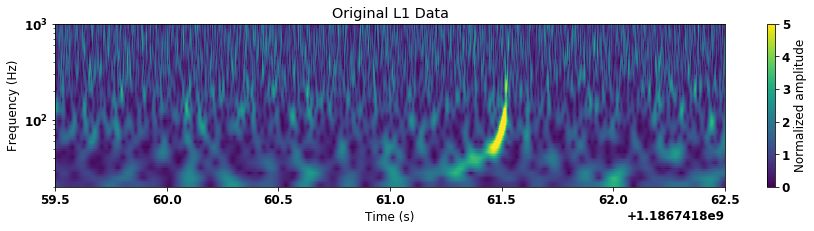

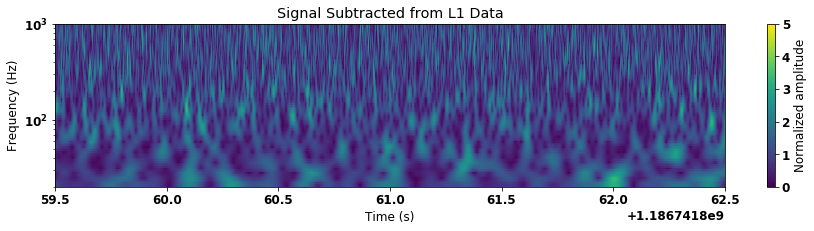

In [42]:
subtracted = strain - best_fit_template

# Plot the original data and the subtracted signal data

for data, title in [(strain, 'Original L1 Data'),
                    (subtracted, 'Signal Subtracted from L1 Data')]:

    t, f, p = data.whiten(4, 4).qtransform(.001,
                                          logfsteps=100,
                                          qrange=(8, 8),
                                          frange=(20, 1000))
    plt.figure(figsize=[15, 3])
    plt.title(title)
    im=plt.pcolormesh(t, f, p**0.5, vmin=0, vmax=5)
    plt.yscale('log')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.xlim(merger.time - 2, merger.time + 1)
    plt.ylim(0,1000)
    cbar=plt.colorbar()
    cbar.ax.set_ylabel("Normalized amplitude")

The subtraction is well performed here

Now we try for the two LGO detectors in order to see if the parameters fit even better

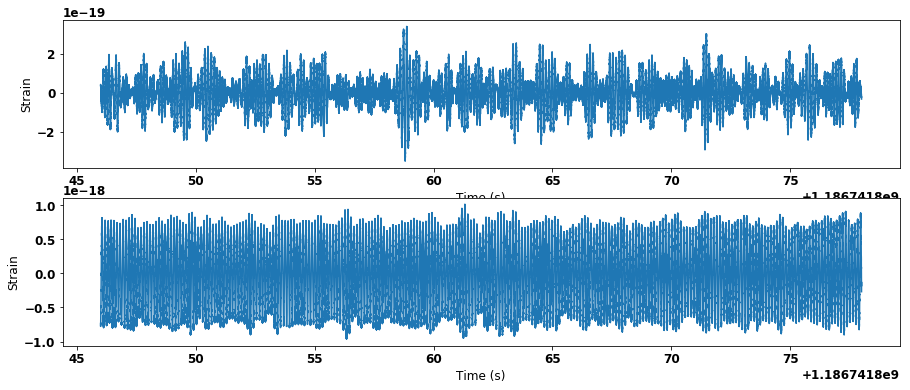

In [43]:
from pycbc.detector import Detector

dets = ['L1', 'H1']

# Get the data from the Hanford detector
strains = dict([(det, merger.strain(det)) for det in dets])

# Remove the low frequency content and downsample the data to 2048Hz
for det, strain in strains.iteritems():
    strain = resample_to_delta_t(highpass(strain, 15.0), 1.0/2048).crop(2, 2)

fig, axs = plt.subplots(2, 1, figsize=[15, 6])
for ax, det in zip(axs, dets):
    ax.plot(strains[det].sample_times, strains[det])
    ax.set_xlabel('Time (s)')
    ax.set_ylabel("Strain")

Text(0.5,1,'PSD for the two LIGO detectors')

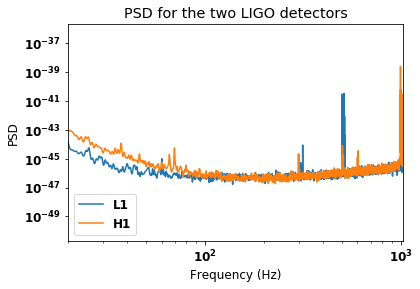

In [44]:
psds = {}

for det in dets:
    psd = strains[det].psd(4)
    psd = interpolate(psd, strains[det].delta_f)

    psds[det] = inverse_spectrum_truncation(psd, 4 * strain.sample_rate)

fs = psd.delta_f * np.arange(psd.data.size)

for det in dets:
    plt.loglog(fs, psds[det], label=det)
plt.xlim(f_lower, f_upper)
plt.xlabel("Frequency (Hz)")
plt.ylabel("PSD")
plt.legend(loc='lower left')
plt.title("PSD for the two LIGO detectors")

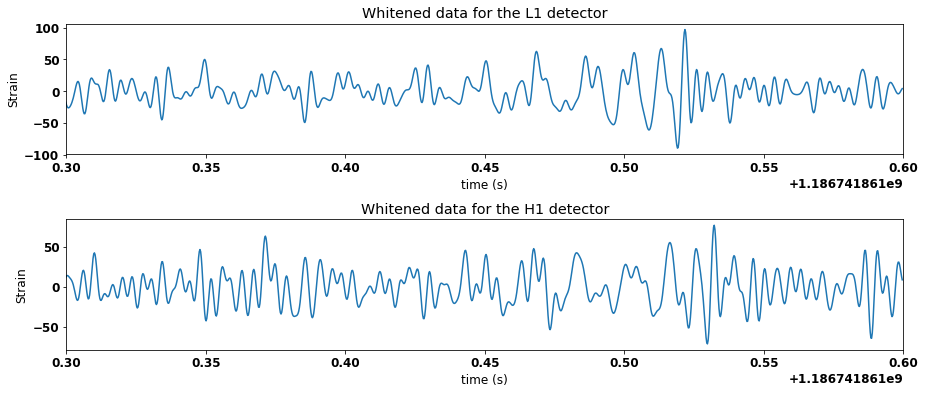

In [45]:
white_net_data = {}
for det in dets:
    white_net_data[det] = (strains[det].to_frequencyseries() / psds[det]**0.5).to_timeseries()
    white_net_data[det] = white_net_data[det].highpass_fir(30., 512).lowpass_fir(300, 512)
    white_net_data[det] = white_net_data[det].time_slice(merger.time-.2, merger.time+.1)
    
fig, axs = plt.subplots(2, 1, figsize=[15, 6])
plt.subplots_adjust(hspace=0.5)
for ax, det in zip(axs, dets):
    ax.plot(white_net_data[det].sample_times, white_net_data[det])
    ax.set_xlabel("time (s)")
    ax.set_xlim(merger.time-.2, merger.time+.1)
    ax.set_ylabel('Strain')
    ax.set_title("Whitened data for the %s detector" %det)
    

In [46]:
def net_gen_template(theta, dets=['L1', 'H1'],
                     delta_t=strains['L1'].delta_t,
                     duration=strains['L1'].duration,
                     start_time=strains['L1'].start_time,
                     f_lower=f_lower):
    m1, m2,spin1z, spin2z, ra, dec, distance, inclination, time, coa_phase, polarization = theta

    # generate geocenter waveform
    hp, hc = get_td_waveform(approximant="SEOBNRv4_opt",
                             mass1=m1,
                             mass2=m2,
                             spin1z=spin1z,
                             spin2z=spin2z,
                             distance=distance,
                             inclination=inclination,
                             coa_phase=coa_phase,
                             delta_t=delta_t,
                             f_lower=f_lower)

    hp.resize(len(strain))
    hc.resize(len(strain))
    hp = hp.cyclic_time_shift(hp.start_time + time - start_time)
    hc = hc.cyclic_time_shift(hc.start_time + time - start_time)

    # project geocenter waveform onto detectors
    h = {}
    for det in dets:
        ifo = Detector(det)
        fp, fc = ifo.antenna_pattern(ra, dec, polarization, time)
        ifo_h = fp*hp.copy() + fc*hc.copy()
        dt = ifo.time_delay_from_earth_center(ra, dec, time)
        h[det] = ifo_h.cyclic_time_shift(dt)
        h[det].start_time = start_time
    return h

In [47]:
# FFT the data once, ahead of time
dfs = dict([(det, strain.to_frequencyseries()) for det, strain in strains.iteritems()])

def net_loglikelihood(theta, dfs=dfs, psds=psds, f_lower=f_lower, f_upper=f_upper):
    dets = dfs.keys()
    logl = 0
    
    # assume identical sampling rates, sampling times, etc.
    df = dfs[dets[0]]
    delta_t = df.delta_t
    duration = df.duration
    N = int(duration/delta_t)
    start_time = df.start_time
    
    # Return p=0 if waveform generation fails
    try:
        hts = net_gen_template(theta, dets=dets, delta_t=delta_t, duration=duration, start_time=start_time, f_lower=f_lower)
    except RuntimeError:
        return -np.inf
    
    # Sum over single-detector likelihoods
    for det, df in dfs.iteritems():
        psd = psds[det]
        hf = hts[det].to_frequencyseries()

        kmin, kmax = filter.get_cutoff_indices(f_lower, f_upper, df.delta_f, (N - 1) * 2)

        hh = sum(4.0 * df.delta_f * (hf[kmin:kmax].conj()*hf[kmin:kmax]).real()/psd[kmin:kmax])
        dh = sum(4.0 * df.delta_f * (df[kmin:kmax].conj()*hf[kmin:kmax]).real()/psd[kmin:kmax])
        logl += -0.5*(hh - 2.0*dh)

    return logl

In [48]:
# m1, m2, spin1z, spin2z, ra, dec, distance, inclination, time, coa_phase, polarization
theta0 = [31.,25., -0.56879753, 0.13079314, 0.833, -0.7845, 540., np.pi, float(merger.time)+0.028, 0., 0.]

net_loglikelihood(theta0)

27.634252251291677

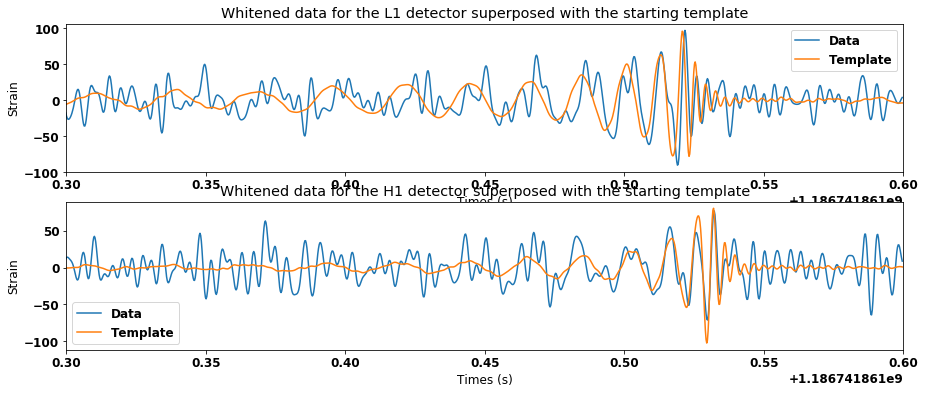

In [49]:
hts = net_gen_template(theta0)
fig, axs = plt.subplots(2, 1, figsize=[15, 6])

lines = {}
for ax, det in zip(axs, dets):
    whitened_template = whiten_trim_template(hts[det], psds[det])

    ax.plot(white_net_data[det].sample_times, white_net_data[det], label="Data")
    lines[det], = ax.plot(whitened_template.sample_times, whitened_template, label="Template")
    ax.set_xlabel("Times (s)")
    ax.set_ylabel('Strain')
    ax.set_xlim(merger.time-.2, merger.time+.1)
    ax.set_title("Whitened data for the %s detector superposed with the starting template" %det)
    ax.legend()

/home/justin/.local/lib/python2.7/site-packages/scipy/optimize/optimize.py:1934: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


KeyboardInterrupt: 

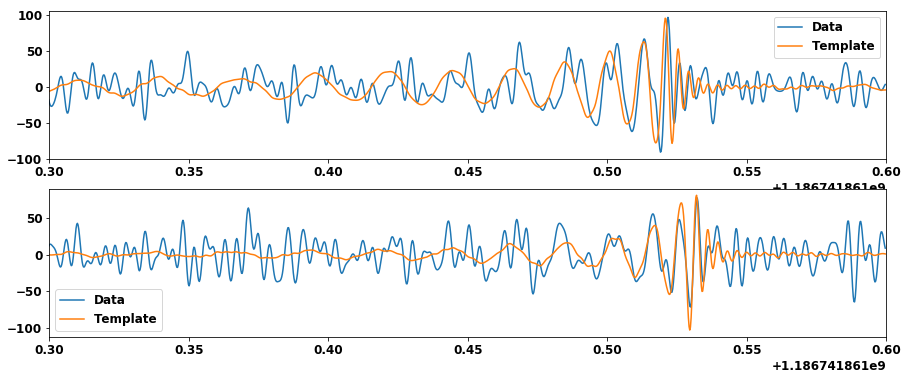

In [50]:
#optimization of the parameters
Neval = 1

fig, axs = plt.subplots(2, 1, figsize=[15, 6])

hts = net_gen_template(theta0)

lines = {}
for ax, det in zip(axs, dets):
    whitened_template = whiten_trim_template(hts[det], psds[det])

    ax.plot(white_net_data[det].sample_times, white_net_data[det], label="Data")
    lines[det], = ax.plot(whitened_template.sample_times, whitened_template, label="Template")

    ax.set_xlim(merger.time-.2, merger.time+.1)
    ax.legend()

def callback(thetai):
    global Neval
    global lines
    global fig
    
    templates = net_gen_template(thetai)
    for det in dets:
        white_template = whiten_trim_template(templates[det], psds[det])
        lines[det].set_ydata(white_template)

    clear_output(wait=True)
    display(fig)
    print("Steps\tlog(likelihood)")
    print('{}\t{:.3f}'.format(Neval, net_loglikelihood(thetai)))
    
    Neval += 1
    
res = minimize(lambda theta: -net_loglikelihood(theta), theta0, callback=callback, method='powell')
plt.close()

In [ ]:
best_fit = res.x
best_fit_templates = net_gen_template(best_fit, start_time=strains["H1"].start_time)
print(best_fit)

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(15, 5))

for i, det in enumerate(dets):
    subtracted = strains[det] - best_fit_templates[det]

    # Plot the original data and the subtracted signal data
    for ax, data, title in [(axs[0][i], strains[det], 'Original {} Data'.format(det)),
                        (axs[1][i], subtracted, 'Signal Subtracted from {} Data'.format(det))]:

        t, f, p = data.whiten(4, 4).qtransform(.001,
                                              logfsteps=100, qrange=(10,10), frange=(20,1000))
        ax.set_title(title)
        im=ax.pcolormesh(t, f, p**0.5, vmin=0, vmax=5)
        ax.set_yscale('log')
        ax.set_xlabel('Time (s)')
        ax.set_ylabel('Frequency (Hz)')
        ax.set_ylim(0,1000)
        ax.set_xlim(merger.time - 2, merger.time + 1)
plt.tight_layout()
cbar_ax = fig.add_axes([1, 0.15, 0.02, 0.7])
cbar=fig.colorbar(im, cax=cbar_ax)
cbar.ax.set_ylabel("Normalized amplitude")


The data is indeed weel subtracted in the two detectors in this case. Note that the banana is less well shown in the H1 detector because of the coor code defined uniformely for the two detectors (which is usually not the case).

We try for three detectors and the spins added to the model

In [ ]:
from pycbc.detector import Detector

dets = ['L1', 'H1', 'V1']

# Get the data from the Hanford detector
strains = dict([(det, merger.strain(det)) for det in dets])

# Remove the low frequency content and downsample the data to 2048Hz
for det, strain in strains.iteritems():
    strain = resample_to_delta_t(highpass(strain, 15.0), 1.0/2048).crop(2, 2)

fig, axs = plt.subplots(3, 1, figsize=[15, 6])
plt.subplots_adjust(hspace=0.7)
for ax, det in zip(axs, dets):
    ax.plot(strains[det].sample_times, strains[det])
    ax.set_xlabel('Time (s)')
    ax.set_ylabel("Strain")
    ax.set_title("Strain for the %s detector" %det)

In [ ]:
psds = {}

for det in dets:
    psd = strains[det].psd(4)
    psd = interpolate(psd, strains[det].delta_f)

    psds[det] = inverse_spectrum_truncation(psd, 4 * strain.sample_rate)

fs = psd.delta_f * np.arange(psd.data.size)

for det in dets:
    plt.loglog(fs, psds[det], label=det)
plt.xlim(f_lower, f_upper)
plt.xlabel("Frequency (Hz)")
plt.ylabel("PSD")
plt.legend(loc='lower left')
plt.title("PSD for the two LIGO and the Virgo detectors")

In [ ]:
white_net_data = {}
for det in dets:
    white_net_data[det] = (strains[det].to_frequencyseries() / psds[det]**0.5).to_timeseries()
    white_net_data[det] = white_net_data[det].highpass_fir(30., 512).lowpass_fir(300, 512)
    white_net_data[det] = white_net_data[det].time_slice(merger.time-.2, merger.time+.1)
    
fig, axs = plt.subplots(3, 1, figsize=[15, 8])
plt.subplots_adjust(hspace=0.6)
for ax, det in zip(axs, dets):
    ax.plot(white_net_data[det].sample_times, white_net_data[det])
    ax.set_xlabel("time (s)")
    ax.set_xlim(merger.time-.2, merger.time+.1)
    ax.set_ylabel('Strain')
    ax.set_title("Whitened data for the %s detector" %det)
    

In [ ]:
def net_gen_template(theta, dets=['L1', 'H1', 'V1'],
                     delta_t=strains['L1'].delta_t,
                     duration=strains['L1'].duration,
                     start_time=strains['L1'].start_time,
                     f_lower=f_lower):
    m1, m2, spin1z, spin2z, ra, dec, distance, inclination, time, coa_phase, polarization = theta

    # generate geocenter waveform
    hp, hc = get_td_waveform(approximant="SEOBNRv4_opt",
                             mass1=m1,
                             mass2=m2,
                             spin1z=spin1z,
                             spin2z=spin2z,
                             distance=distance,
                             inclination=inclination,
                             coa_phase=coa_phase,
                             delta_t=delta_t,
                             f_lower=f_lower)

    hp.resize(len(strain))
    hc.resize(len(strain))
    hp = hp.cyclic_time_shift(hp.start_time + time - start_time)
    hc = hc.cyclic_time_shift(hc.start_time + time - start_time)

    # project geocenter waveform onto detectors
    h = {}
    for det in dets:
        ifo = Detector(det)
        fp, fc = ifo.antenna_pattern(ra, dec, polarization, time)
        ifo_h = fp*hp.copy() + fc*hc.copy()
        dt = ifo.time_delay_from_earth_center(ra, dec, time)
        h[det] = ifo_h.cyclic_time_shift(dt)
        h[det].start_time = start_time
    return h

In [ ]:
# FFT the data once, ahead of time
dfs = dict([(det, strain.to_frequencyseries()) for det, strain in strains.iteritems()])

def net_loglikelihood(theta, dfs=dfs, psds=psds, f_lower=f_lower, f_upper=f_upper):
    dets = dfs.keys()
    logl = 0
    
    # assume identical sampling rates, sampling times, etc.
    df = dfs[dets[0]]
    delta_t = df.delta_t
    duration = df.duration
    N = int(duration/delta_t)
    start_time = df.start_time
    
    # Return p=0 if waveform generation fails
    try:
        hts = net_gen_template(theta, dets=dets, delta_t=delta_t, duration=duration, start_time=start_time, f_lower=f_lower)
    except RuntimeError:
        return -np.inf
    
    # Sum over single-detector likelihoods
    for det, df in dfs.iteritems():
        psd = psds[det]
        hf = hts[det].to_frequencyseries()

        kmin, kmax = filter.get_cutoff_indices(f_lower, f_upper, df.delta_f, (N - 1) * 2)

        hh = sum(4.0 * df.delta_f * (hf[kmin:kmax].conj()*hf[kmin:kmax]).real()/psd[kmin:kmax])
        dh = sum(4.0 * df.delta_f * (df[kmin:kmax].conj()*hf[kmin:kmax]).real()/psd[kmin:kmax])
        logl += -0.5*(hh - 2.0*dh)

    return logl

In [ ]:
# m1, m2, spin1z, spin2z, ra, dec, distance, inclination, time, coa_phase, polarization
theta0 = [31.,25.,-0.56879753, 0.13079314,0.833, -0.7845, 540., np.pi, float(merger.time)+0.028, 0., 0.]

net_loglikelihood(theta0)

In [ ]:
hts = net_gen_template(theta0)
fig, axs = plt.subplots(3, 1, figsize=[20, 15])
plt.subplots_adjust(hspace=0.6)
lines = {}
for ax, det in zip(axs, dets):
    whitened_template = whiten_trim_template(hts[det], psds[det])

    ax.plot(white_net_data[det].sample_times, white_net_data[det], label="Data")
    lines[det], = ax.plot(whitened_template.sample_times, whitened_template, label="Template")
    ax.set_xlabel("Times (s)")
    ax.set_ylabel('Strain')
    ax.set_xlim(merger.time-.2, merger.time+.1)
    ax.set_title("Whitened data for the %s detector superposed with the starting template" %det)
    ax.legend()

In [ ]:
#optimization of the parameters
Neval = 1

fig, axs = plt.subplots(3, 1, figsize=[15, 6])

hts = net_gen_template(theta0)

lines = {}
for ax, det in zip(axs, dets):
    whitened_template = whiten_trim_template(hts[det], psds[det])

    ax.plot(white_net_data[det].sample_times, white_net_data[det], label="Data")
    lines[det], = ax.plot(whitened_template.sample_times, whitened_template, label="Template")

    ax.set_xlim(merger.time-.2, merger.time+.1)
    ax.legend()

def callback(thetai):
    global Neval
    global lines
    global fig
    
    templates = net_gen_template(thetai)
    for det in dets:
        white_template = whiten_trim_template(templates[det], psds[det])
        lines[det].set_ydata(white_template)

    clear_output(wait=True)
    display(fig)
    print("Steps\tlog(likelihood)")
    print('{}\t{:.3f}'.format(Neval, net_loglikelihood(thetai)))
    
    Neval += 1
    
res = minimize(lambda theta: -net_loglikelihood(theta), theta0, callback=callback, method='powell')
plt.close()

In [ ]:
best_fit = res.x
best_fit_templates = net_gen_template(best_fit, start_time=strains["H1"].start_time)
print(best_fit)

In [1]:
fig, axs = plt.subplots(2, 3, figsize=(20, 10))

for i, det in enumerate(dets):
    subtracted = strains[det] - best_fit_templates[det]
    # Plot the original data and the subtracted signal data
    for ax, data, title in [(axs[0][i], strains[det], 'Original {} Data'.format(det)),
                        (axs[1][i], subtracted, 'Signal Subtracted from {} Data'.format(det))]:

        t, f, p = data.whiten(4, 4).qtransform(.001,
                                              logfsteps=100,
                                              qrange=(10, 10),
                                              frange=(20, 1000))
        ax.set_title(title)
        im=ax.pcolormesh(t, f, p**0.5, vmin=0, vmax=5)
        ax.set_yscale('log')
        ax.set_xlabel('Time (s)')
        ax.set_ylabel('Frequency (Hz)')
        ax.set_ylim(0,1000)
        ax.set_xlim(merger.time - 0.07, merger.time + 0.07)
plt.tight_layout()
cbar_ax = fig.add_axes([1, 0.15, 0.02, 0.7])
cbar=fig.colorbar(im, cax=cbar_ax)
cbar.ax.set_ylabel("Normalized amplitude")

NameError: name 'plt' is not defined

# Comparioson of the plus and cross polarization
A figure made in order to have a better view on the difference between the plus and the cross polarization in the case of the IMRPHenomD model. It is justt in order to see the influence

In [ ]:
%matplotlib inline 

#first we need to set bigger characters for the titles, labels and thicks.
import matplotlib
import matplotlib.pyplot as plt
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 12}

matplotlib.rc('font', **font)
from pycbc.waveform import get_td_waveform

# The output of this function are the "plus" and "cross" polarizations of the gravitational-wave signal 
# as viewed from the line of sight at a given source inclination (assumed face-on if not provided)
hp, hc = get_td_waveform(approximant="IMRPhenomD",
                         mass1=10,
                         mass2=10,
                         delta_t=1.0/4096,
                         f_lower=30)

plt.plot(hp.sample_times, hp, label='Plus Polarization')
plt.plot(hp.sample_times, hc, label='Cross Polarization')
plt.xlabel('Time (s)')
plt.xlim(-1.0,0.01)
plt.legend()
plt.grid()
plt.show()

# Zoom in near the merger time#
plt.figure(figsize=[8,5])
plt.plot(hp.sample_times, hp, label='Plus Polarization')
plt.plot(hp.sample_times, hc, label='Cross Polarization')
plt.xlabel('Time (s)')
plt.xlim(-.01, .01)
plt.legend()
plt.grid()
plt.title("Plus and cross polarization for the IMRPhenomD model", pad=20)
plt.show()